In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn,functional
from torch.autograd import Variable
from torchvision import transforms


import torchvision
import torchvision.transforms as transforms
%matplotlib inline

In [2]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [3]:
location=''

train=pd.read_csv(location+'mnist_train.csv')[:200]
X_train=torch.from_numpy(train.loc[:,train.columns != "label"].values/255)
Y_train=torch.from_numpy(train.label.values).type(torch.LongTensor)

test=pd.read_csv(location+'mnist_test.csv')
X_test=torch.from_numpy(test.loc[:,train.columns != "label"].values/255)
Y_test=torch.from_numpy(test.label.values).type(torch.LongTensor)

train = torch.utils.data.TensorDataset(X_train,Y_train)
test = torch.utils.data.TensorDataset(X_test,Y_test)

train_loader = torch.utils.data.DataLoader(train, batch_size = 1, shuffle = True)
test_loader = torch.utils.data.DataLoader(test, batch_size = 10, shuffle = True)

In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.c1=nn.Conv2d(in_channels=1, out_channels=8, stride=2, kernel_size=4, padding=1)
        self.l1=nn.Linear(288, 10)
        
        self.dropout=nn.Dropout(p=0.2)
        self.maxpool=nn.MaxPool2d(kernel_size=3, stride=2)
        self.relu=nn.ReLU()
        
    def forward(self, x):
        x=self.c1(x)
        x=self.relu(x)
        x=self.maxpool(x)

        x=x.view(x.size(0), -1)

        x=self.l1(x)
        
        return x

In [5]:
class Adv(nn.Module):
    def __init__(self):
        super(Adv, self).__init__()

        self.c1=nn.Conv2d(in_channels=1, out_channels=8, stride=2, kernel_size=4, padding=1)
        self.l1=nn.Linear(288+1, 512)
        self.l2=nn.Linear(512, 784)

        self.dropout=nn.Dropout(p=0.2)
        self.maxpool=nn.MaxPool2d(kernel_size=3, stride=2)
        self.relu=nn.ReLU()
        self.sigmoid=nn.Sigmoid()

        
    def forward(self, x):
        x=self.c1(x)
        x=self.relu(x)
        x=self.maxpool(x)

        x=x.view(x.size(0), -1)
        r=torch.randn(x.size(0), 1)
        x=torch.cat((x,r), 1)

        x=self.l1(x)
        x=self.dropout(x)
        x=self.l2(x)
        x=self.relu(x)
        x=self.sigmoid(x)

        return x

In [6]:
class Adv2(nn.Module):
    def __init__(self):
        super(Adv2, self).__init__()

        self.c1=nn.Conv2d(in_channels=1, out_channels=8, stride=2, kernel_size=4, padding=1)
        self.l1=nn.Linear(288+1, 64)
        self.l2=nn.Linear(64, 128)
        self.l3=nn.Linear(128, 784)

        self.dropout=nn.Dropout(p=0.2)
        self.maxpool=nn.MaxPool2d(kernel_size=3, stride=2)
        self.relu=nn.ReLU()
        self.sigmoid=nn.Sigmoid()

        
    def forward(self, x):
        x=self.c1(x)
        x=self.relu(x)
        x=self.maxpool(x)

        x=x.view(x.size(0), -1)
        r=torch.randn(x.size(0), 1)
        x=torch.cat((x,r), 1)

        x=self.l1(x)
        x=self.dropout(x)
        x=self.l2(x)
        x=self.dropout(x)
        x=self.l3(x)
        x=self.relu(x)
        x=self.sigmoid(x)

        return x

In [7]:
class Adv3(nn.Module):
    def __init__(self):
        super(Adv3, self).__init__()

        self.c1=nn.Conv2d(in_channels=1, out_channels=16, stride=2, kernel_size=3, padding=1)
        self.c2=nn.Conv2d(in_channels=16, out_channels=32, stride=2, kernel_size=3, padding=1)
        self.l1=nn.Linear(32, 64)
        self.l2=nn.Linear(64, 128)
        self.l3=nn.Linear(128, 784)

        self.dropout=nn.Dropout(p=0.2)
        self.maxpool=nn.MaxPool2d(kernel_size=3, stride=2)
        self.relu=nn.LeakyReLU(negative_slope=0.1)
        self.final=nn.Tanh()

        
    def forward(self, x):
        x=self.c1(x)
        x=self.relu(x)
        x=self.maxpool(x)
        
        x=self.c2(x)
        x=self.relu(x)
        x=self.maxpool(x)

        x=x.view(x.size(0), -1)

        x=self.l1(x)
        x=x+torch.randn(x.shape)
        x=self.dropout(x)
        
        x=self.l2(x)
        x=self.dropout(x)
        
        x=self.l3(x)
        x=self.relu(x)
        x=self.final(x)

        return x

# Baseline CNN


In [8]:
basecnn=CNN()
basecnn=basecnn.double()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(basecnn.parameters(), lr=0.0001)

train_losses_basecnn, test_losses_basecnn, accuracy_graph_basecnn = [], [], []

In [9]:
epochs = 1500

for epoch in range(epochs):
    running_loss = 0

    for images,labels in train_loader:

        train = Variable(images.view(-1,1,28,28))
        labels = Variable(labels)
        
        optimizer.zero_grad()
        
        output = basecnn(train)
        loss = criterion(output,labels)

        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        test_loss = 0
        accuracy = 0
        
        with torch.no_grad(): #Turning off gradients to speed up
            basecnn.eval()
            for images,labels in test_loader:
                
                test = Variable(images.view(-1,1,28,28))
                labels = Variable(labels)
                
                log_ps = basecnn(test)
                test_loss += criterion(log_ps,labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim = 1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))

        basecnn.train()        
        train_losses_basecnn.append(running_loss/len(train_loader))
        test_losses_basecnn.append(test_loss/len(test_loader))
        accuracy_graph_basecnn.append(accuracy/len(test_loader))

        print("Epoch: {}/{}.. ".format(epoch+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(test_loader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))

Epoch: 1/1500..  Training Loss: 2.310..  Test Loss: 2.283..  Test Accuracy: 0.140
Epoch: 2/1500..  Training Loss: 2.220..  Test Loss: 2.225..  Test Accuracy: 0.200
Epoch: 3/1500..  Training Loss: 2.150..  Test Loss: 2.173..  Test Accuracy: 0.257
Epoch: 4/1500..  Training Loss: 2.079..  Test Loss: 2.113..  Test Accuracy: 0.334
Epoch: 5/1500..  Training Loss: 2.002..  Test Loss: 2.049..  Test Accuracy: 0.393
Epoch: 6/1500..  Training Loss: 1.912..  Test Loss: 1.979..  Test Accuracy: 0.437
Epoch: 7/1500..  Training Loss: 1.817..  Test Loss: 1.903..  Test Accuracy: 0.477
Epoch: 8/1500..  Training Loss: 1.712..  Test Loss: 1.820..  Test Accuracy: 0.502
Epoch: 9/1500..  Training Loss: 1.608..  Test Loss: 1.736..  Test Accuracy: 0.521
Epoch: 10/1500..  Training Loss: 1.500..  Test Loss: 1.652..  Test Accuracy: 0.542
Epoch: 11/1500..  Training Loss: 1.396..  Test Loss: 1.581..  Test Accuracy: 0.564
Epoch: 12/1500..  Training Loss: 1.301..  Test Loss: 1.511..  Test Accuracy: 0.572
Epoch: 13/150

Epoch: 100/1500..  Training Loss: 0.064..  Test Loss: 1.055..  Test Accuracy: 0.754
Epoch: 101/1500..  Training Loss: 0.063..  Test Loss: 1.087..  Test Accuracy: 0.750
Epoch: 102/1500..  Training Loss: 0.062..  Test Loss: 1.056..  Test Accuracy: 0.755
Epoch: 103/1500..  Training Loss: 0.058..  Test Loss: 1.071..  Test Accuracy: 0.755
Epoch: 104/1500..  Training Loss: 0.057..  Test Loss: 1.085..  Test Accuracy: 0.754
Epoch: 105/1500..  Training Loss: 0.055..  Test Loss: 1.101..  Test Accuracy: 0.752
Epoch: 106/1500..  Training Loss: 0.053..  Test Loss: 1.072..  Test Accuracy: 0.756
Epoch: 107/1500..  Training Loss: 0.051..  Test Loss: 1.081..  Test Accuracy: 0.756
Epoch: 108/1500..  Training Loss: 0.050..  Test Loss: 1.087..  Test Accuracy: 0.755
Epoch: 109/1500..  Training Loss: 0.049..  Test Loss: 1.093..  Test Accuracy: 0.751
Epoch: 110/1500..  Training Loss: 0.046..  Test Loss: 1.100..  Test Accuracy: 0.759
Epoch: 111/1500..  Training Loss: 0.046..  Test Loss: 1.146..  Test Accuracy

Epoch: 198/1500..  Training Loss: 0.002..  Test Loss: 1.794..  Test Accuracy: 0.747
Epoch: 199/1500..  Training Loss: 0.002..  Test Loss: 1.773..  Test Accuracy: 0.746
Epoch: 200/1500..  Training Loss: 0.002..  Test Loss: 1.782..  Test Accuracy: 0.749
Epoch: 201/1500..  Training Loss: 0.002..  Test Loss: 1.793..  Test Accuracy: 0.743
Epoch: 202/1500..  Training Loss: 0.002..  Test Loss: 1.835..  Test Accuracy: 0.744
Epoch: 203/1500..  Training Loss: 0.002..  Test Loss: 1.790..  Test Accuracy: 0.746
Epoch: 204/1500..  Training Loss: 0.002..  Test Loss: 1.807..  Test Accuracy: 0.747
Epoch: 205/1500..  Training Loss: 0.002..  Test Loss: 1.812..  Test Accuracy: 0.747
Epoch: 206/1500..  Training Loss: 0.002..  Test Loss: 1.851..  Test Accuracy: 0.746
Epoch: 207/1500..  Training Loss: 0.001..  Test Loss: 1.892..  Test Accuracy: 0.740
Epoch: 208/1500..  Training Loss: 0.002..  Test Loss: 1.840..  Test Accuracy: 0.748
Epoch: 209/1500..  Training Loss: 0.001..  Test Loss: 1.859..  Test Accuracy

Epoch: 296/1500..  Training Loss: 0.000..  Test Loss: 2.726..  Test Accuracy: 0.744
Epoch: 297/1500..  Training Loss: 0.000..  Test Loss: 2.676..  Test Accuracy: 0.747
Epoch: 298/1500..  Training Loss: 0.000..  Test Loss: 2.701..  Test Accuracy: 0.746
Epoch: 299/1500..  Training Loss: 0.000..  Test Loss: 2.688..  Test Accuracy: 0.749
Epoch: 300/1500..  Training Loss: 0.000..  Test Loss: 2.758..  Test Accuracy: 0.744
Epoch: 301/1500..  Training Loss: 0.000..  Test Loss: 2.763..  Test Accuracy: 0.745
Epoch: 302/1500..  Training Loss: 0.000..  Test Loss: 2.743..  Test Accuracy: 0.747
Epoch: 303/1500..  Training Loss: 0.000..  Test Loss: 2.740..  Test Accuracy: 0.747
Epoch: 304/1500..  Training Loss: 0.000..  Test Loss: 2.779..  Test Accuracy: 0.744
Epoch: 305/1500..  Training Loss: 0.000..  Test Loss: 2.790..  Test Accuracy: 0.747
Epoch: 306/1500..  Training Loss: 0.000..  Test Loss: 2.807..  Test Accuracy: 0.744
Epoch: 307/1500..  Training Loss: 0.000..  Test Loss: 2.832..  Test Accuracy

Epoch: 394/1500..  Training Loss: 0.000..  Test Loss: 3.712..  Test Accuracy: 0.744
Epoch: 395/1500..  Training Loss: 0.000..  Test Loss: 3.700..  Test Accuracy: 0.744
Epoch: 396/1500..  Training Loss: 0.000..  Test Loss: 3.673..  Test Accuracy: 0.746
Epoch: 397/1500..  Training Loss: 0.000..  Test Loss: 3.691..  Test Accuracy: 0.746
Epoch: 398/1500..  Training Loss: 0.000..  Test Loss: 3.710..  Test Accuracy: 0.747
Epoch: 399/1500..  Training Loss: 0.000..  Test Loss: 3.704..  Test Accuracy: 0.746
Epoch: 400/1500..  Training Loss: 0.000..  Test Loss: 3.727..  Test Accuracy: 0.746
Epoch: 401/1500..  Training Loss: 0.000..  Test Loss: 3.719..  Test Accuracy: 0.745
Epoch: 402/1500..  Training Loss: 0.000..  Test Loss: 3.781..  Test Accuracy: 0.744
Epoch: 403/1500..  Training Loss: 0.000..  Test Loss: 3.761..  Test Accuracy: 0.745
Epoch: 404/1500..  Training Loss: 0.000..  Test Loss: 3.770..  Test Accuracy: 0.746
Epoch: 405/1500..  Training Loss: 0.000..  Test Loss: 3.811..  Test Accuracy

Epoch: 492/1500..  Training Loss: 0.000..  Test Loss: 4.552..  Test Accuracy: 0.745
Epoch: 493/1500..  Training Loss: 0.000..  Test Loss: 4.529..  Test Accuracy: 0.747
Epoch: 494/1500..  Training Loss: 0.000..  Test Loss: 4.551..  Test Accuracy: 0.744
Epoch: 495/1500..  Training Loss: 0.000..  Test Loss: 4.577..  Test Accuracy: 0.744
Epoch: 496/1500..  Training Loss: 0.000..  Test Loss: 4.602..  Test Accuracy: 0.743
Epoch: 497/1500..  Training Loss: 0.000..  Test Loss: 4.573..  Test Accuracy: 0.746
Epoch: 498/1500..  Training Loss: 0.000..  Test Loss: 4.580..  Test Accuracy: 0.745
Epoch: 499/1500..  Training Loss: 0.000..  Test Loss: 4.596..  Test Accuracy: 0.744
Epoch: 500/1500..  Training Loss: 0.000..  Test Loss: 4.593..  Test Accuracy: 0.744
Epoch: 501/1500..  Training Loss: 0.000..  Test Loss: 4.592..  Test Accuracy: 0.746
Epoch: 502/1500..  Training Loss: 0.000..  Test Loss: 4.591..  Test Accuracy: 0.745
Epoch: 503/1500..  Training Loss: 0.000..  Test Loss: 4.632..  Test Accuracy

Epoch: 590/1500..  Training Loss: 0.000..  Test Loss: 4.865..  Test Accuracy: 0.745
Epoch: 591/1500..  Training Loss: 0.000..  Test Loss: 4.889..  Test Accuracy: 0.744
Epoch: 592/1500..  Training Loss: 0.000..  Test Loss: 4.881..  Test Accuracy: 0.744
Epoch: 593/1500..  Training Loss: 0.000..  Test Loss: 4.861..  Test Accuracy: 0.745
Epoch: 594/1500..  Training Loss: 0.000..  Test Loss: 4.879..  Test Accuracy: 0.745
Epoch: 595/1500..  Training Loss: 0.000..  Test Loss: 4.883..  Test Accuracy: 0.744
Epoch: 596/1500..  Training Loss: 0.000..  Test Loss: 4.870..  Test Accuracy: 0.745
Epoch: 597/1500..  Training Loss: 0.000..  Test Loss: 4.881..  Test Accuracy: 0.744
Epoch: 598/1500..  Training Loss: 0.000..  Test Loss: 4.866..  Test Accuracy: 0.745
Epoch: 599/1500..  Training Loss: 0.000..  Test Loss: 4.887..  Test Accuracy: 0.745
Epoch: 600/1500..  Training Loss: 0.000..  Test Loss: 4.900..  Test Accuracy: 0.744
Epoch: 601/1500..  Training Loss: 0.000..  Test Loss: 4.880..  Test Accuracy

Epoch: 688/1500..  Training Loss: 0.000..  Test Loss: 4.967..  Test Accuracy: 0.746
Epoch: 689/1500..  Training Loss: 0.000..  Test Loss: 4.974..  Test Accuracy: 0.746
Epoch: 690/1500..  Training Loss: 0.000..  Test Loss: 4.979..  Test Accuracy: 0.745
Epoch: 691/1500..  Training Loss: 0.000..  Test Loss: 4.976..  Test Accuracy: 0.746
Epoch: 692/1500..  Training Loss: 0.000..  Test Loss: 4.972..  Test Accuracy: 0.745
Epoch: 693/1500..  Training Loss: 0.000..  Test Loss: 4.971..  Test Accuracy: 0.746
Epoch: 694/1500..  Training Loss: 0.000..  Test Loss: 4.972..  Test Accuracy: 0.746
Epoch: 695/1500..  Training Loss: 0.000..  Test Loss: 4.975..  Test Accuracy: 0.745
Epoch: 696/1500..  Training Loss: 0.000..  Test Loss: 4.975..  Test Accuracy: 0.746
Epoch: 697/1500..  Training Loss: 0.000..  Test Loss: 4.975..  Test Accuracy: 0.745
Epoch: 698/1500..  Training Loss: 0.000..  Test Loss: 4.976..  Test Accuracy: 0.745
Epoch: 699/1500..  Training Loss: 0.000..  Test Loss: 4.974..  Test Accuracy

Epoch: 786/1500..  Training Loss: 0.000..  Test Loss: 5.028..  Test Accuracy: 0.745
Epoch: 787/1500..  Training Loss: 0.000..  Test Loss: 5.026..  Test Accuracy: 0.746
Epoch: 788/1500..  Training Loss: 0.000..  Test Loss: 5.031..  Test Accuracy: 0.745
Epoch: 789/1500..  Training Loss: 0.000..  Test Loss: 5.033..  Test Accuracy: 0.745
Epoch: 790/1500..  Training Loss: 0.000..  Test Loss: 5.029..  Test Accuracy: 0.745
Epoch: 791/1500..  Training Loss: 0.000..  Test Loss: 5.029..  Test Accuracy: 0.745
Epoch: 792/1500..  Training Loss: 0.000..  Test Loss: 5.029..  Test Accuracy: 0.745
Epoch: 793/1500..  Training Loss: 0.000..  Test Loss: 5.030..  Test Accuracy: 0.746
Epoch: 794/1500..  Training Loss: 0.000..  Test Loss: 5.027..  Test Accuracy: 0.746
Epoch: 795/1500..  Training Loss: 0.000..  Test Loss: 5.032..  Test Accuracy: 0.745
Epoch: 796/1500..  Training Loss: 0.000..  Test Loss: 5.028..  Test Accuracy: 0.746
Epoch: 797/1500..  Training Loss: 0.000..  Test Loss: 5.029..  Test Accuracy

Epoch: 884/1500..  Training Loss: 0.000..  Test Loss: 5.066..  Test Accuracy: 0.746
Epoch: 885/1500..  Training Loss: 0.000..  Test Loss: 5.064..  Test Accuracy: 0.746
Epoch: 886/1500..  Training Loss: 0.000..  Test Loss: 5.065..  Test Accuracy: 0.746
Epoch: 887/1500..  Training Loss: 0.000..  Test Loss: 5.065..  Test Accuracy: 0.746
Epoch: 888/1500..  Training Loss: 0.000..  Test Loss: 5.065..  Test Accuracy: 0.746
Epoch: 889/1500..  Training Loss: 0.000..  Test Loss: 5.065..  Test Accuracy: 0.746
Epoch: 890/1500..  Training Loss: 0.000..  Test Loss: 5.064..  Test Accuracy: 0.746
Epoch: 891/1500..  Training Loss: 0.000..  Test Loss: 5.067..  Test Accuracy: 0.746
Epoch: 892/1500..  Training Loss: 0.000..  Test Loss: 5.066..  Test Accuracy: 0.746
Epoch: 893/1500..  Training Loss: 0.000..  Test Loss: 5.065..  Test Accuracy: 0.746
Epoch: 894/1500..  Training Loss: 0.000..  Test Loss: 5.066..  Test Accuracy: 0.746
Epoch: 895/1500..  Training Loss: 0.000..  Test Loss: 5.065..  Test Accuracy

Epoch: 982/1500..  Training Loss: 0.000..  Test Loss: 5.092..  Test Accuracy: 0.747
Epoch: 983/1500..  Training Loss: 0.000..  Test Loss: 5.092..  Test Accuracy: 0.747
Epoch: 984/1500..  Training Loss: 0.000..  Test Loss: 5.094..  Test Accuracy: 0.746
Epoch: 985/1500..  Training Loss: 0.000..  Test Loss: 5.094..  Test Accuracy: 0.747
Epoch: 986/1500..  Training Loss: 0.000..  Test Loss: 5.094..  Test Accuracy: 0.747
Epoch: 987/1500..  Training Loss: 0.000..  Test Loss: 5.094..  Test Accuracy: 0.747
Epoch: 988/1500..  Training Loss: 0.000..  Test Loss: 5.095..  Test Accuracy: 0.747
Epoch: 989/1500..  Training Loss: 0.000..  Test Loss: 5.093..  Test Accuracy: 0.747
Epoch: 990/1500..  Training Loss: 0.000..  Test Loss: 5.096..  Test Accuracy: 0.747
Epoch: 991/1500..  Training Loss: 0.000..  Test Loss: 5.096..  Test Accuracy: 0.747
Epoch: 992/1500..  Training Loss: 0.000..  Test Loss: 5.096..  Test Accuracy: 0.747
Epoch: 993/1500..  Training Loss: 0.000..  Test Loss: 5.096..  Test Accuracy

Epoch: 1079/1500..  Training Loss: 0.000..  Test Loss: 5.116..  Test Accuracy: 0.747
Epoch: 1080/1500..  Training Loss: 0.000..  Test Loss: 5.115..  Test Accuracy: 0.747
Epoch: 1081/1500..  Training Loss: 0.000..  Test Loss: 5.116..  Test Accuracy: 0.747
Epoch: 1082/1500..  Training Loss: 0.000..  Test Loss: 5.117..  Test Accuracy: 0.747
Epoch: 1083/1500..  Training Loss: 0.000..  Test Loss: 5.118..  Test Accuracy: 0.747
Epoch: 1084/1500..  Training Loss: 0.000..  Test Loss: 5.117..  Test Accuracy: 0.747
Epoch: 1085/1500..  Training Loss: 0.000..  Test Loss: 5.118..  Test Accuracy: 0.747
Epoch: 1086/1500..  Training Loss: 0.000..  Test Loss: 5.117..  Test Accuracy: 0.747
Epoch: 1087/1500..  Training Loss: 0.000..  Test Loss: 5.117..  Test Accuracy: 0.747
Epoch: 1088/1500..  Training Loss: 0.000..  Test Loss: 5.118..  Test Accuracy: 0.747
Epoch: 1089/1500..  Training Loss: 0.000..  Test Loss: 5.117..  Test Accuracy: 0.747
Epoch: 1090/1500..  Training Loss: 0.000..  Test Loss: 5.117..  T

Epoch: 1176/1500..  Training Loss: 0.000..  Test Loss: 5.135..  Test Accuracy: 0.747
Epoch: 1177/1500..  Training Loss: 0.000..  Test Loss: 5.134..  Test Accuracy: 0.747
Epoch: 1178/1500..  Training Loss: 0.000..  Test Loss: 5.136..  Test Accuracy: 0.747
Epoch: 1179/1500..  Training Loss: 0.000..  Test Loss: 5.136..  Test Accuracy: 0.747
Epoch: 1180/1500..  Training Loss: 0.000..  Test Loss: 5.136..  Test Accuracy: 0.747
Epoch: 1181/1500..  Training Loss: 0.000..  Test Loss: 5.136..  Test Accuracy: 0.747
Epoch: 1182/1500..  Training Loss: 0.000..  Test Loss: 5.135..  Test Accuracy: 0.747
Epoch: 1183/1500..  Training Loss: 0.000..  Test Loss: 5.136..  Test Accuracy: 0.747
Epoch: 1184/1500..  Training Loss: 0.000..  Test Loss: 5.136..  Test Accuracy: 0.747
Epoch: 1185/1500..  Training Loss: 0.000..  Test Loss: 5.136..  Test Accuracy: 0.747
Epoch: 1186/1500..  Training Loss: 0.000..  Test Loss: 5.137..  Test Accuracy: 0.747
Epoch: 1187/1500..  Training Loss: 0.000..  Test Loss: 5.136..  T

Epoch: 1273/1500..  Training Loss: 0.000..  Test Loss: 5.151..  Test Accuracy: 0.748
Epoch: 1274/1500..  Training Loss: 0.000..  Test Loss: 5.153..  Test Accuracy: 0.747
Epoch: 1275/1500..  Training Loss: 0.000..  Test Loss: 5.151..  Test Accuracy: 0.748
Epoch: 1276/1500..  Training Loss: 0.000..  Test Loss: 5.152..  Test Accuracy: 0.748
Epoch: 1277/1500..  Training Loss: 0.000..  Test Loss: 5.152..  Test Accuracy: 0.748
Epoch: 1278/1500..  Training Loss: 0.000..  Test Loss: 5.152..  Test Accuracy: 0.748
Epoch: 1279/1500..  Training Loss: 0.000..  Test Loss: 5.152..  Test Accuracy: 0.747
Epoch: 1280/1500..  Training Loss: 0.000..  Test Loss: 5.152..  Test Accuracy: 0.747
Epoch: 1281/1500..  Training Loss: 0.000..  Test Loss: 5.153..  Test Accuracy: 0.747
Epoch: 1282/1500..  Training Loss: 0.000..  Test Loss: 5.153..  Test Accuracy: 0.748
Epoch: 1283/1500..  Training Loss: 0.000..  Test Loss: 5.153..  Test Accuracy: 0.747
Epoch: 1284/1500..  Training Loss: 0.000..  Test Loss: 5.154..  T

Epoch: 1370/1500..  Training Loss: 0.000..  Test Loss: 5.166..  Test Accuracy: 0.748
Epoch: 1371/1500..  Training Loss: 0.000..  Test Loss: 5.165..  Test Accuracy: 0.748
Epoch: 1372/1500..  Training Loss: 0.000..  Test Loss: 5.166..  Test Accuracy: 0.748
Epoch: 1373/1500..  Training Loss: 0.000..  Test Loss: 5.166..  Test Accuracy: 0.748
Epoch: 1374/1500..  Training Loss: 0.000..  Test Loss: 5.166..  Test Accuracy: 0.748
Epoch: 1375/1500..  Training Loss: 0.000..  Test Loss: 5.167..  Test Accuracy: 0.748
Epoch: 1376/1500..  Training Loss: 0.000..  Test Loss: 5.167..  Test Accuracy: 0.748
Epoch: 1377/1500..  Training Loss: 0.000..  Test Loss: 5.167..  Test Accuracy: 0.748
Epoch: 1378/1500..  Training Loss: 0.000..  Test Loss: 5.167..  Test Accuracy: 0.748
Epoch: 1379/1500..  Training Loss: 0.000..  Test Loss: 5.167..  Test Accuracy: 0.748
Epoch: 1380/1500..  Training Loss: 0.000..  Test Loss: 5.168..  Test Accuracy: 0.748
Epoch: 1381/1500..  Training Loss: 0.000..  Test Loss: 5.168..  T

Epoch: 1467/1500..  Training Loss: 0.000..  Test Loss: 5.179..  Test Accuracy: 0.748
Epoch: 1468/1500..  Training Loss: 0.000..  Test Loss: 5.179..  Test Accuracy: 0.748
Epoch: 1469/1500..  Training Loss: 0.000..  Test Loss: 5.179..  Test Accuracy: 0.748
Epoch: 1470/1500..  Training Loss: 0.000..  Test Loss: 5.179..  Test Accuracy: 0.748
Epoch: 1471/1500..  Training Loss: 0.000..  Test Loss: 5.180..  Test Accuracy: 0.748
Epoch: 1472/1500..  Training Loss: 0.000..  Test Loss: 5.180..  Test Accuracy: 0.748
Epoch: 1473/1500..  Training Loss: 0.000..  Test Loss: 5.179..  Test Accuracy: 0.748
Epoch: 1474/1500..  Training Loss: 0.000..  Test Loss: 5.181..  Test Accuracy: 0.748
Epoch: 1475/1500..  Training Loss: 0.000..  Test Loss: 5.180..  Test Accuracy: 0.748
Epoch: 1476/1500..  Training Loss: 0.000..  Test Loss: 5.180..  Test Accuracy: 0.748
Epoch: 1477/1500..  Training Loss: 0.000..  Test Loss: 5.181..  Test Accuracy: 0.748
Epoch: 1478/1500..  Training Loss: 0.000..  Test Loss: 5.180..  T

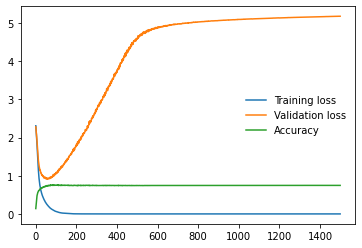

In [88]:
plt.plot(train_losses_basecnn, label='Training loss')
plt.plot(test_losses_basecnn, label='Validation loss')
plt.plot(accuracy_graph_basecnn, label='Accuracy')
plt.legend(frameon=False)

# Gaussian Mask Input CNN

In [11]:
gcnn=CNN()
gcnn=gcnn.double()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gcnn.parameters(), lr=0.0001)

train_losses_gcnn, test_losses_gcnn, accuracy_graph_gcnn = [], [], []

sample_images_gcnn=[]
sample_masked_gcnn=[]

In [12]:
epochs = 4000

for epoch in range(epochs):
    running_loss = 0
    mask_loss = 0

    currentdropout = 0.95
    
    if(epoch>400):
      currentdropout=0.75
    else:
      currentdropout = 0.95 - epoch*(0.15/400)

    i=0

    for images,labels in train_loader:
        train = Variable(images.view(-1,1,28,28))
        labels = Variable(labels)

        if(i==0 and epoch%10==0):
          sample_images_gcnn.append(train.clone().detach().numpy())

        optimizer.zero_grad()

        drop = nn.Dropout(p=currentdropout)
        mask = drop(torch.rand(images.shape).double())

        images = images + mask
        images = torch.minimum(images, torch.ones(images.shape))
        train = Variable(images.view(-1,1,28,28))

        if(i==0 and epoch%10==0):
          sample_masked_gcnn.append(train.clone().detach().numpy())

        output = gcnn(train)

        loss = criterion(output, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        i+=1

    else:
        test_loss = 0
        accuracy = 0
        
        with torch.no_grad(): #Turning off gradients to speed up
            gcnn.eval()
            for images,labels in test_loader:
                
                test = Variable(images.view(-1,1,28,28))
                labels = Variable(labels)
                
                log_ps = gcnn(test)
                test_loss += criterion(log_ps,labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim = 1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))

        gcnn.train()        
        train_losses_gcnn.append(running_loss/len(train_loader))
        test_losses_gcnn.append(test_loss/len(test_loader))
        accuracy_graph_gcnn.append(accuracy/len(test_loader))

        print("Epoch: {}/{}.. ".format(epoch+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(test_loader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))

Epoch: 1/4000..  Training Loss: 2.317..  Test Loss: 2.278..  Test Accuracy: 0.112
Epoch: 2/4000..  Training Loss: 2.268..  Test Loss: 2.260..  Test Accuracy: 0.195
Epoch: 3/4000..  Training Loss: 2.245..  Test Loss: 2.243..  Test Accuracy: 0.268
Epoch: 4/4000..  Training Loss: 2.222..  Test Loss: 2.224..  Test Accuracy: 0.312
Epoch: 5/4000..  Training Loss: 2.200..  Test Loss: 2.202..  Test Accuracy: 0.340
Epoch: 6/4000..  Training Loss: 2.173..  Test Loss: 2.178..  Test Accuracy: 0.382
Epoch: 7/4000..  Training Loss: 2.147..  Test Loss: 2.149..  Test Accuracy: 0.432
Epoch: 8/4000..  Training Loss: 2.118..  Test Loss: 2.114..  Test Accuracy: 0.459
Epoch: 9/4000..  Training Loss: 2.075..  Test Loss: 2.082..  Test Accuracy: 0.459
Epoch: 10/4000..  Training Loss: 2.039..  Test Loss: 2.043..  Test Accuracy: 0.482
Epoch: 11/4000..  Training Loss: 1.994..  Test Loss: 1.999..  Test Accuracy: 0.496
Epoch: 12/4000..  Training Loss: 1.947..  Test Loss: 1.956..  Test Accuracy: 0.514
Epoch: 13/400

Epoch: 100/4000..  Training Loss: 0.339..  Test Loss: 0.857..  Test Accuracy: 0.709
Epoch: 101/4000..  Training Loss: 0.327..  Test Loss: 0.848..  Test Accuracy: 0.715
Epoch: 102/4000..  Training Loss: 0.312..  Test Loss: 0.865..  Test Accuracy: 0.707
Epoch: 103/4000..  Training Loss: 0.302..  Test Loss: 0.846..  Test Accuracy: 0.716
Epoch: 104/4000..  Training Loss: 0.294..  Test Loss: 0.836..  Test Accuracy: 0.718
Epoch: 105/4000..  Training Loss: 0.300..  Test Loss: 0.868..  Test Accuracy: 0.711
Epoch: 106/4000..  Training Loss: 0.286..  Test Loss: 0.864..  Test Accuracy: 0.708
Epoch: 107/4000..  Training Loss: 0.293..  Test Loss: 0.870..  Test Accuracy: 0.708
Epoch: 108/4000..  Training Loss: 0.289..  Test Loss: 0.876..  Test Accuracy: 0.710
Epoch: 109/4000..  Training Loss: 0.264..  Test Loss: 0.843..  Test Accuracy: 0.720
Epoch: 110/4000..  Training Loss: 0.255..  Test Loss: 0.848..  Test Accuracy: 0.719
Epoch: 111/4000..  Training Loss: 0.289..  Test Loss: 0.886..  Test Accuracy

Epoch: 198/4000..  Training Loss: 0.122..  Test Loss: 0.819..  Test Accuracy: 0.764
Epoch: 199/4000..  Training Loss: 0.143..  Test Loss: 0.794..  Test Accuracy: 0.771
Epoch: 200/4000..  Training Loss: 0.161..  Test Loss: 0.803..  Test Accuracy: 0.772
Epoch: 201/4000..  Training Loss: 0.141..  Test Loss: 0.822..  Test Accuracy: 0.758
Epoch: 202/4000..  Training Loss: 0.142..  Test Loss: 0.849..  Test Accuracy: 0.756
Epoch: 203/4000..  Training Loss: 0.143..  Test Loss: 0.853..  Test Accuracy: 0.759
Epoch: 204/4000..  Training Loss: 0.144..  Test Loss: 0.852..  Test Accuracy: 0.755
Epoch: 205/4000..  Training Loss: 0.107..  Test Loss: 0.813..  Test Accuracy: 0.766
Epoch: 206/4000..  Training Loss: 0.129..  Test Loss: 0.852..  Test Accuracy: 0.762
Epoch: 207/4000..  Training Loss: 0.142..  Test Loss: 0.836..  Test Accuracy: 0.767
Epoch: 208/4000..  Training Loss: 0.123..  Test Loss: 0.813..  Test Accuracy: 0.766
Epoch: 209/4000..  Training Loss: 0.125..  Test Loss: 0.826..  Test Accuracy

Epoch: 296/4000..  Training Loss: 0.089..  Test Loss: 0.867..  Test Accuracy: 0.780
Epoch: 297/4000..  Training Loss: 0.093..  Test Loss: 0.921..  Test Accuracy: 0.766
Epoch: 298/4000..  Training Loss: 0.092..  Test Loss: 0.924..  Test Accuracy: 0.767
Epoch: 299/4000..  Training Loss: 0.087..  Test Loss: 0.875..  Test Accuracy: 0.780
Epoch: 300/4000..  Training Loss: 0.109..  Test Loss: 0.933..  Test Accuracy: 0.773
Epoch: 301/4000..  Training Loss: 0.077..  Test Loss: 0.866..  Test Accuracy: 0.783
Epoch: 302/4000..  Training Loss: 0.084..  Test Loss: 0.907..  Test Accuracy: 0.773
Epoch: 303/4000..  Training Loss: 0.078..  Test Loss: 0.865..  Test Accuracy: 0.779
Epoch: 304/4000..  Training Loss: 0.096..  Test Loss: 0.902..  Test Accuracy: 0.776
Epoch: 305/4000..  Training Loss: 0.087..  Test Loss: 0.932..  Test Accuracy: 0.770
Epoch: 306/4000..  Training Loss: 0.067..  Test Loss: 0.887..  Test Accuracy: 0.777
Epoch: 307/4000..  Training Loss: 0.090..  Test Loss: 0.894..  Test Accuracy

Epoch: 394/4000..  Training Loss: 0.059..  Test Loss: 0.952..  Test Accuracy: 0.781
Epoch: 395/4000..  Training Loss: 0.086..  Test Loss: 1.012..  Test Accuracy: 0.773
Epoch: 396/4000..  Training Loss: 0.085..  Test Loss: 0.989..  Test Accuracy: 0.778
Epoch: 397/4000..  Training Loss: 0.079..  Test Loss: 0.933..  Test Accuracy: 0.783
Epoch: 398/4000..  Training Loss: 0.069..  Test Loss: 0.929..  Test Accuracy: 0.786
Epoch: 399/4000..  Training Loss: 0.079..  Test Loss: 0.955..  Test Accuracy: 0.782
Epoch: 400/4000..  Training Loss: 0.061..  Test Loss: 1.002..  Test Accuracy: 0.775
Epoch: 401/4000..  Training Loss: 0.082..  Test Loss: 0.919..  Test Accuracy: 0.786
Epoch: 402/4000..  Training Loss: 0.107..  Test Loss: 0.957..  Test Accuracy: 0.777
Epoch: 403/4000..  Training Loss: 0.089..  Test Loss: 1.007..  Test Accuracy: 0.770
Epoch: 404/4000..  Training Loss: 0.103..  Test Loss: 1.024..  Test Accuracy: 0.768
Epoch: 405/4000..  Training Loss: 0.105..  Test Loss: 1.004..  Test Accuracy

Epoch: 492/4000..  Training Loss: 0.073..  Test Loss: 1.004..  Test Accuracy: 0.778
Epoch: 493/4000..  Training Loss: 0.084..  Test Loss: 0.947..  Test Accuracy: 0.792
Epoch: 494/4000..  Training Loss: 0.062..  Test Loss: 1.045..  Test Accuracy: 0.775
Epoch: 495/4000..  Training Loss: 0.049..  Test Loss: 0.999..  Test Accuracy: 0.781
Epoch: 496/4000..  Training Loss: 0.079..  Test Loss: 1.003..  Test Accuracy: 0.780
Epoch: 497/4000..  Training Loss: 0.094..  Test Loss: 0.992..  Test Accuracy: 0.783
Epoch: 498/4000..  Training Loss: 0.088..  Test Loss: 0.982..  Test Accuracy: 0.784
Epoch: 499/4000..  Training Loss: 0.058..  Test Loss: 0.986..  Test Accuracy: 0.786
Epoch: 500/4000..  Training Loss: 0.068..  Test Loss: 0.990..  Test Accuracy: 0.783
Epoch: 501/4000..  Training Loss: 0.095..  Test Loss: 1.000..  Test Accuracy: 0.779
Epoch: 502/4000..  Training Loss: 0.085..  Test Loss: 0.972..  Test Accuracy: 0.783
Epoch: 503/4000..  Training Loss: 0.072..  Test Loss: 1.035..  Test Accuracy

Epoch: 590/4000..  Training Loss: 0.077..  Test Loss: 0.934..  Test Accuracy: 0.798
Epoch: 591/4000..  Training Loss: 0.053..  Test Loss: 0.942..  Test Accuracy: 0.799
Epoch: 592/4000..  Training Loss: 0.059..  Test Loss: 0.958..  Test Accuracy: 0.794
Epoch: 593/4000..  Training Loss: 0.069..  Test Loss: 0.922..  Test Accuracy: 0.799
Epoch: 594/4000..  Training Loss: 0.084..  Test Loss: 0.974..  Test Accuracy: 0.793
Epoch: 595/4000..  Training Loss: 0.070..  Test Loss: 0.976..  Test Accuracy: 0.794
Epoch: 596/4000..  Training Loss: 0.032..  Test Loss: 0.960..  Test Accuracy: 0.797
Epoch: 597/4000..  Training Loss: 0.052..  Test Loss: 0.953..  Test Accuracy: 0.797
Epoch: 598/4000..  Training Loss: 0.077..  Test Loss: 0.991..  Test Accuracy: 0.790
Epoch: 599/4000..  Training Loss: 0.084..  Test Loss: 0.944..  Test Accuracy: 0.799
Epoch: 600/4000..  Training Loss: 0.074..  Test Loss: 0.988..  Test Accuracy: 0.790
Epoch: 601/4000..  Training Loss: 0.059..  Test Loss: 0.958..  Test Accuracy

Epoch: 688/4000..  Training Loss: 0.040..  Test Loss: 0.934..  Test Accuracy: 0.802
Epoch: 689/4000..  Training Loss: 0.054..  Test Loss: 0.939..  Test Accuracy: 0.803
Epoch: 690/4000..  Training Loss: 0.040..  Test Loss: 0.911..  Test Accuracy: 0.805
Epoch: 691/4000..  Training Loss: 0.042..  Test Loss: 0.966..  Test Accuracy: 0.800
Epoch: 692/4000..  Training Loss: 0.083..  Test Loss: 0.971..  Test Accuracy: 0.794
Epoch: 693/4000..  Training Loss: 0.047..  Test Loss: 0.918..  Test Accuracy: 0.807
Epoch: 694/4000..  Training Loss: 0.047..  Test Loss: 0.949..  Test Accuracy: 0.804
Epoch: 695/4000..  Training Loss: 0.055..  Test Loss: 0.965..  Test Accuracy: 0.800
Epoch: 696/4000..  Training Loss: 0.036..  Test Loss: 0.991..  Test Accuracy: 0.798
Epoch: 697/4000..  Training Loss: 0.039..  Test Loss: 1.004..  Test Accuracy: 0.796
Epoch: 698/4000..  Training Loss: 0.049..  Test Loss: 1.020..  Test Accuracy: 0.793
Epoch: 699/4000..  Training Loss: 0.047..  Test Loss: 0.974..  Test Accuracy

Epoch: 786/4000..  Training Loss: 0.028..  Test Loss: 0.972..  Test Accuracy: 0.805
Epoch: 787/4000..  Training Loss: 0.061..  Test Loss: 0.952..  Test Accuracy: 0.810
Epoch: 788/4000..  Training Loss: 0.042..  Test Loss: 0.988..  Test Accuracy: 0.804
Epoch: 789/4000..  Training Loss: 0.032..  Test Loss: 0.964..  Test Accuracy: 0.807
Epoch: 790/4000..  Training Loss: 0.023..  Test Loss: 0.969..  Test Accuracy: 0.806
Epoch: 791/4000..  Training Loss: 0.053..  Test Loss: 1.000..  Test Accuracy: 0.799
Epoch: 792/4000..  Training Loss: 0.041..  Test Loss: 0.964..  Test Accuracy: 0.804
Epoch: 793/4000..  Training Loss: 0.030..  Test Loss: 1.014..  Test Accuracy: 0.799
Epoch: 794/4000..  Training Loss: 0.044..  Test Loss: 0.959..  Test Accuracy: 0.806
Epoch: 795/4000..  Training Loss: 0.039..  Test Loss: 1.046..  Test Accuracy: 0.796
Epoch: 796/4000..  Training Loss: 0.048..  Test Loss: 1.010..  Test Accuracy: 0.801
Epoch: 797/4000..  Training Loss: 0.040..  Test Loss: 0.970..  Test Accuracy

Epoch: 884/4000..  Training Loss: 0.030..  Test Loss: 0.961..  Test Accuracy: 0.810
Epoch: 885/4000..  Training Loss: 0.027..  Test Loss: 0.956..  Test Accuracy: 0.812
Epoch: 886/4000..  Training Loss: 0.040..  Test Loss: 0.913..  Test Accuracy: 0.815
Epoch: 887/4000..  Training Loss: 0.029..  Test Loss: 0.934..  Test Accuracy: 0.814
Epoch: 888/4000..  Training Loss: 0.037..  Test Loss: 0.968..  Test Accuracy: 0.808
Epoch: 889/4000..  Training Loss: 0.049..  Test Loss: 0.924..  Test Accuracy: 0.814
Epoch: 890/4000..  Training Loss: 0.040..  Test Loss: 0.986..  Test Accuracy: 0.808
Epoch: 891/4000..  Training Loss: 0.025..  Test Loss: 0.924..  Test Accuracy: 0.816
Epoch: 892/4000..  Training Loss: 0.056..  Test Loss: 0.987..  Test Accuracy: 0.806
Epoch: 893/4000..  Training Loss: 0.058..  Test Loss: 0.904..  Test Accuracy: 0.816
Epoch: 894/4000..  Training Loss: 0.029..  Test Loss: 0.926..  Test Accuracy: 0.815
Epoch: 895/4000..  Training Loss: 0.019..  Test Loss: 0.944..  Test Accuracy

Epoch: 982/4000..  Training Loss: 0.049..  Test Loss: 1.040..  Test Accuracy: 0.802
Epoch: 983/4000..  Training Loss: 0.029..  Test Loss: 1.000..  Test Accuracy: 0.808
Epoch: 984/4000..  Training Loss: 0.038..  Test Loss: 0.947..  Test Accuracy: 0.817
Epoch: 985/4000..  Training Loss: 0.038..  Test Loss: 0.980..  Test Accuracy: 0.806
Epoch: 986/4000..  Training Loss: 0.046..  Test Loss: 0.946..  Test Accuracy: 0.815
Epoch: 987/4000..  Training Loss: 0.034..  Test Loss: 0.968..  Test Accuracy: 0.811
Epoch: 988/4000..  Training Loss: 0.030..  Test Loss: 1.017..  Test Accuracy: 0.806
Epoch: 989/4000..  Training Loss: 0.039..  Test Loss: 0.977..  Test Accuracy: 0.811
Epoch: 990/4000..  Training Loss: 0.043..  Test Loss: 0.987..  Test Accuracy: 0.809
Epoch: 991/4000..  Training Loss: 0.041..  Test Loss: 1.015..  Test Accuracy: 0.806
Epoch: 992/4000..  Training Loss: 0.043..  Test Loss: 0.989..  Test Accuracy: 0.809
Epoch: 993/4000..  Training Loss: 0.029..  Test Loss: 1.000..  Test Accuracy

Epoch: 1079/4000..  Training Loss: 0.017..  Test Loss: 0.976..  Test Accuracy: 0.813
Epoch: 1080/4000..  Training Loss: 0.014..  Test Loss: 0.980..  Test Accuracy: 0.813
Epoch: 1081/4000..  Training Loss: 0.032..  Test Loss: 1.038..  Test Accuracy: 0.803
Epoch: 1082/4000..  Training Loss: 0.033..  Test Loss: 1.040..  Test Accuracy: 0.808
Epoch: 1083/4000..  Training Loss: 0.032..  Test Loss: 1.076..  Test Accuracy: 0.801
Epoch: 1084/4000..  Training Loss: 0.032..  Test Loss: 1.033..  Test Accuracy: 0.806
Epoch: 1085/4000..  Training Loss: 0.039..  Test Loss: 1.032..  Test Accuracy: 0.807
Epoch: 1086/4000..  Training Loss: 0.029..  Test Loss: 1.033..  Test Accuracy: 0.803
Epoch: 1087/4000..  Training Loss: 0.036..  Test Loss: 0.975..  Test Accuracy: 0.812
Epoch: 1088/4000..  Training Loss: 0.022..  Test Loss: 0.998..  Test Accuracy: 0.811
Epoch: 1089/4000..  Training Loss: 0.021..  Test Loss: 0.951..  Test Accuracy: 0.816
Epoch: 1090/4000..  Training Loss: 0.019..  Test Loss: 1.013..  T

Epoch: 1176/4000..  Training Loss: 0.029..  Test Loss: 0.983..  Test Accuracy: 0.820
Epoch: 1177/4000..  Training Loss: 0.050..  Test Loss: 1.065..  Test Accuracy: 0.806
Epoch: 1178/4000..  Training Loss: 0.027..  Test Loss: 1.016..  Test Accuracy: 0.813
Epoch: 1179/4000..  Training Loss: 0.017..  Test Loss: 1.009..  Test Accuracy: 0.813
Epoch: 1180/4000..  Training Loss: 0.058..  Test Loss: 0.972..  Test Accuracy: 0.818
Epoch: 1181/4000..  Training Loss: 0.029..  Test Loss: 0.974..  Test Accuracy: 0.816
Epoch: 1182/4000..  Training Loss: 0.045..  Test Loss: 0.962..  Test Accuracy: 0.819
Epoch: 1183/4000..  Training Loss: 0.014..  Test Loss: 0.974..  Test Accuracy: 0.816
Epoch: 1184/4000..  Training Loss: 0.025..  Test Loss: 0.997..  Test Accuracy: 0.811
Epoch: 1185/4000..  Training Loss: 0.036..  Test Loss: 1.004..  Test Accuracy: 0.813
Epoch: 1186/4000..  Training Loss: 0.035..  Test Loss: 1.027..  Test Accuracy: 0.808
Epoch: 1187/4000..  Training Loss: 0.018..  Test Loss: 1.032..  T

Epoch: 1273/4000..  Training Loss: 0.026..  Test Loss: 1.025..  Test Accuracy: 0.815
Epoch: 1274/4000..  Training Loss: 0.022..  Test Loss: 1.028..  Test Accuracy: 0.812
Epoch: 1275/4000..  Training Loss: 0.018..  Test Loss: 1.004..  Test Accuracy: 0.816
Epoch: 1276/4000..  Training Loss: 0.028..  Test Loss: 0.951..  Test Accuracy: 0.820
Epoch: 1277/4000..  Training Loss: 0.043..  Test Loss: 1.049..  Test Accuracy: 0.810
Epoch: 1278/4000..  Training Loss: 0.027..  Test Loss: 1.030..  Test Accuracy: 0.814
Epoch: 1279/4000..  Training Loss: 0.023..  Test Loss: 1.049..  Test Accuracy: 0.811
Epoch: 1280/4000..  Training Loss: 0.028..  Test Loss: 1.029..  Test Accuracy: 0.814
Epoch: 1281/4000..  Training Loss: 0.014..  Test Loss: 1.029..  Test Accuracy: 0.815
Epoch: 1282/4000..  Training Loss: 0.031..  Test Loss: 0.992..  Test Accuracy: 0.817
Epoch: 1283/4000..  Training Loss: 0.047..  Test Loss: 0.968..  Test Accuracy: 0.819
Epoch: 1284/4000..  Training Loss: 0.020..  Test Loss: 0.957..  T

Epoch: 1370/4000..  Training Loss: 0.010..  Test Loss: 1.020..  Test Accuracy: 0.816
Epoch: 1371/4000..  Training Loss: 0.022..  Test Loss: 1.014..  Test Accuracy: 0.816
Epoch: 1372/4000..  Training Loss: 0.028..  Test Loss: 0.983..  Test Accuracy: 0.820
Epoch: 1373/4000..  Training Loss: 0.045..  Test Loss: 1.022..  Test Accuracy: 0.817
Epoch: 1374/4000..  Training Loss: 0.015..  Test Loss: 1.049..  Test Accuracy: 0.814
Epoch: 1375/4000..  Training Loss: 0.012..  Test Loss: 0.984..  Test Accuracy: 0.820
Epoch: 1376/4000..  Training Loss: 0.042..  Test Loss: 1.011..  Test Accuracy: 0.817
Epoch: 1377/4000..  Training Loss: 0.036..  Test Loss: 1.032..  Test Accuracy: 0.813
Epoch: 1378/4000..  Training Loss: 0.020..  Test Loss: 0.995..  Test Accuracy: 0.819
Epoch: 1379/4000..  Training Loss: 0.016..  Test Loss: 1.044..  Test Accuracy: 0.813
Epoch: 1380/4000..  Training Loss: 0.012..  Test Loss: 1.053..  Test Accuracy: 0.814
Epoch: 1381/4000..  Training Loss: 0.024..  Test Loss: 1.032..  T

Epoch: 1467/4000..  Training Loss: 0.015..  Test Loss: 1.021..  Test Accuracy: 0.818
Epoch: 1468/4000..  Training Loss: 0.032..  Test Loss: 0.992..  Test Accuracy: 0.823
Epoch: 1469/4000..  Training Loss: 0.025..  Test Loss: 1.001..  Test Accuracy: 0.822
Epoch: 1470/4000..  Training Loss: 0.050..  Test Loss: 1.029..  Test Accuracy: 0.817
Epoch: 1471/4000..  Training Loss: 0.045..  Test Loss: 1.024..  Test Accuracy: 0.820
Epoch: 1472/4000..  Training Loss: 0.037..  Test Loss: 1.022..  Test Accuracy: 0.817
Epoch: 1473/4000..  Training Loss: 0.011..  Test Loss: 0.985..  Test Accuracy: 0.822
Epoch: 1474/4000..  Training Loss: 0.044..  Test Loss: 0.996..  Test Accuracy: 0.821
Epoch: 1475/4000..  Training Loss: 0.024..  Test Loss: 0.975..  Test Accuracy: 0.824
Epoch: 1476/4000..  Training Loss: 0.018..  Test Loss: 0.986..  Test Accuracy: 0.824
Epoch: 1477/4000..  Training Loss: 0.038..  Test Loss: 0.998..  Test Accuracy: 0.821
Epoch: 1478/4000..  Training Loss: 0.008..  Test Loss: 0.974..  T

Epoch: 1564/4000..  Training Loss: 0.012..  Test Loss: 0.990..  Test Accuracy: 0.825
Epoch: 1565/4000..  Training Loss: 0.012..  Test Loss: 0.996..  Test Accuracy: 0.824
Epoch: 1566/4000..  Training Loss: 0.010..  Test Loss: 0.996..  Test Accuracy: 0.824
Epoch: 1567/4000..  Training Loss: 0.033..  Test Loss: 1.002..  Test Accuracy: 0.821
Epoch: 1568/4000..  Training Loss: 0.027..  Test Loss: 1.029..  Test Accuracy: 0.819
Epoch: 1569/4000..  Training Loss: 0.014..  Test Loss: 1.059..  Test Accuracy: 0.817
Epoch: 1570/4000..  Training Loss: 0.016..  Test Loss: 1.105..  Test Accuracy: 0.811
Epoch: 1571/4000..  Training Loss: 0.012..  Test Loss: 0.988..  Test Accuracy: 0.826
Epoch: 1572/4000..  Training Loss: 0.024..  Test Loss: 1.077..  Test Accuracy: 0.815
Epoch: 1573/4000..  Training Loss: 0.027..  Test Loss: 1.031..  Test Accuracy: 0.818
Epoch: 1574/4000..  Training Loss: 0.050..  Test Loss: 1.054..  Test Accuracy: 0.816
Epoch: 1575/4000..  Training Loss: 0.015..  Test Loss: 0.994..  T

Epoch: 1661/4000..  Training Loss: 0.008..  Test Loss: 1.033..  Test Accuracy: 0.824
Epoch: 1662/4000..  Training Loss: 0.009..  Test Loss: 1.061..  Test Accuracy: 0.819
Epoch: 1663/4000..  Training Loss: 0.018..  Test Loss: 1.051..  Test Accuracy: 0.821
Epoch: 1664/4000..  Training Loss: 0.011..  Test Loss: 1.033..  Test Accuracy: 0.822
Epoch: 1665/4000..  Training Loss: 0.014..  Test Loss: 1.044..  Test Accuracy: 0.821
Epoch: 1666/4000..  Training Loss: 0.018..  Test Loss: 1.028..  Test Accuracy: 0.822
Epoch: 1667/4000..  Training Loss: 0.027..  Test Loss: 1.028..  Test Accuracy: 0.825
Epoch: 1668/4000..  Training Loss: 0.033..  Test Loss: 1.038..  Test Accuracy: 0.822
Epoch: 1669/4000..  Training Loss: 0.027..  Test Loss: 1.034..  Test Accuracy: 0.823
Epoch: 1670/4000..  Training Loss: 0.019..  Test Loss: 0.990..  Test Accuracy: 0.828
Epoch: 1671/4000..  Training Loss: 0.015..  Test Loss: 0.992..  Test Accuracy: 0.827
Epoch: 1672/4000..  Training Loss: 0.016..  Test Loss: 1.049..  T

Epoch: 1758/4000..  Training Loss: 0.008..  Test Loss: 1.023..  Test Accuracy: 0.825
Epoch: 1759/4000..  Training Loss: 0.007..  Test Loss: 1.011..  Test Accuracy: 0.826
Epoch: 1760/4000..  Training Loss: 0.011..  Test Loss: 1.022..  Test Accuracy: 0.824
Epoch: 1761/4000..  Training Loss: 0.018..  Test Loss: 1.028..  Test Accuracy: 0.823
Epoch: 1762/4000..  Training Loss: 0.021..  Test Loss: 1.061..  Test Accuracy: 0.821
Epoch: 1763/4000..  Training Loss: 0.011..  Test Loss: 1.034..  Test Accuracy: 0.820
Epoch: 1764/4000..  Training Loss: 0.034..  Test Loss: 0.943..  Test Accuracy: 0.831
Epoch: 1765/4000..  Training Loss: 0.033..  Test Loss: 0.967..  Test Accuracy: 0.830
Epoch: 1766/4000..  Training Loss: 0.009..  Test Loss: 0.971..  Test Accuracy: 0.832
Epoch: 1767/4000..  Training Loss: 0.028..  Test Loss: 1.004..  Test Accuracy: 0.823
Epoch: 1768/4000..  Training Loss: 0.017..  Test Loss: 0.956..  Test Accuracy: 0.830
Epoch: 1769/4000..  Training Loss: 0.009..  Test Loss: 0.999..  T

Epoch: 1855/4000..  Training Loss: 0.010..  Test Loss: 1.020..  Test Accuracy: 0.823
Epoch: 1856/4000..  Training Loss: 0.016..  Test Loss: 1.021..  Test Accuracy: 0.825
Epoch: 1857/4000..  Training Loss: 0.017..  Test Loss: 1.042..  Test Accuracy: 0.822
Epoch: 1858/4000..  Training Loss: 0.012..  Test Loss: 0.989..  Test Accuracy: 0.829
Epoch: 1859/4000..  Training Loss: 0.016..  Test Loss: 1.040..  Test Accuracy: 0.819
Epoch: 1860/4000..  Training Loss: 0.022..  Test Loss: 1.109..  Test Accuracy: 0.816
Epoch: 1861/4000..  Training Loss: 0.018..  Test Loss: 1.016..  Test Accuracy: 0.825
Epoch: 1862/4000..  Training Loss: 0.012..  Test Loss: 1.084..  Test Accuracy: 0.818
Epoch: 1863/4000..  Training Loss: 0.020..  Test Loss: 1.150..  Test Accuracy: 0.806
Epoch: 1864/4000..  Training Loss: 0.016..  Test Loss: 1.092..  Test Accuracy: 0.816
Epoch: 1865/4000..  Training Loss: 0.013..  Test Loss: 1.044..  Test Accuracy: 0.823
Epoch: 1866/4000..  Training Loss: 0.011..  Test Loss: 1.048..  T

Epoch: 1952/4000..  Training Loss: 0.012..  Test Loss: 1.039..  Test Accuracy: 0.822
Epoch: 1953/4000..  Training Loss: 0.009..  Test Loss: 1.010..  Test Accuracy: 0.828
Epoch: 1954/4000..  Training Loss: 0.013..  Test Loss: 1.021..  Test Accuracy: 0.825
Epoch: 1955/4000..  Training Loss: 0.014..  Test Loss: 1.011..  Test Accuracy: 0.828
Epoch: 1956/4000..  Training Loss: 0.020..  Test Loss: 1.025..  Test Accuracy: 0.827
Epoch: 1957/4000..  Training Loss: 0.007..  Test Loss: 1.046..  Test Accuracy: 0.822
Epoch: 1958/4000..  Training Loss: 0.024..  Test Loss: 1.012..  Test Accuracy: 0.830
Epoch: 1959/4000..  Training Loss: 0.021..  Test Loss: 1.053..  Test Accuracy: 0.824
Epoch: 1960/4000..  Training Loss: 0.021..  Test Loss: 1.182..  Test Accuracy: 0.810
Epoch: 1961/4000..  Training Loss: 0.039..  Test Loss: 1.077..  Test Accuracy: 0.820
Epoch: 1962/4000..  Training Loss: 0.015..  Test Loss: 1.031..  Test Accuracy: 0.827
Epoch: 1963/4000..  Training Loss: 0.016..  Test Loss: 1.058..  T

Epoch: 2049/4000..  Training Loss: 0.017..  Test Loss: 1.061..  Test Accuracy: 0.821
Epoch: 2050/4000..  Training Loss: 0.014..  Test Loss: 1.059..  Test Accuracy: 0.824
Epoch: 2051/4000..  Training Loss: 0.007..  Test Loss: 1.096..  Test Accuracy: 0.817
Epoch: 2052/4000..  Training Loss: 0.013..  Test Loss: 1.020..  Test Accuracy: 0.827
Epoch: 2053/4000..  Training Loss: 0.014..  Test Loss: 1.011..  Test Accuracy: 0.826
Epoch: 2054/4000..  Training Loss: 0.010..  Test Loss: 1.034..  Test Accuracy: 0.828
Epoch: 2055/4000..  Training Loss: 0.025..  Test Loss: 1.042..  Test Accuracy: 0.822
Epoch: 2056/4000..  Training Loss: 0.027..  Test Loss: 1.081..  Test Accuracy: 0.821
Epoch: 2057/4000..  Training Loss: 0.010..  Test Loss: 1.105..  Test Accuracy: 0.817
Epoch: 2058/4000..  Training Loss: 0.024..  Test Loss: 1.076..  Test Accuracy: 0.820
Epoch: 2059/4000..  Training Loss: 0.018..  Test Loss: 1.139..  Test Accuracy: 0.806
Epoch: 2060/4000..  Training Loss: 0.027..  Test Loss: 1.052..  T

Epoch: 2146/4000..  Training Loss: 0.004..  Test Loss: 1.033..  Test Accuracy: 0.829
Epoch: 2147/4000..  Training Loss: 0.006..  Test Loss: 1.040..  Test Accuracy: 0.827
Epoch: 2148/4000..  Training Loss: 0.018..  Test Loss: 1.090..  Test Accuracy: 0.818
Epoch: 2149/4000..  Training Loss: 0.027..  Test Loss: 1.199..  Test Accuracy: 0.811
Epoch: 2150/4000..  Training Loss: 0.011..  Test Loss: 1.103..  Test Accuracy: 0.819
Epoch: 2151/4000..  Training Loss: 0.013..  Test Loss: 1.082..  Test Accuracy: 0.820
Epoch: 2152/4000..  Training Loss: 0.018..  Test Loss: 1.063..  Test Accuracy: 0.824
Epoch: 2153/4000..  Training Loss: 0.008..  Test Loss: 1.053..  Test Accuracy: 0.825
Epoch: 2154/4000..  Training Loss: 0.019..  Test Loss: 1.130..  Test Accuracy: 0.816
Epoch: 2155/4000..  Training Loss: 0.014..  Test Loss: 1.102..  Test Accuracy: 0.819
Epoch: 2156/4000..  Training Loss: 0.008..  Test Loss: 1.124..  Test Accuracy: 0.817
Epoch: 2157/4000..  Training Loss: 0.042..  Test Loss: 0.990..  T

Epoch: 2243/4000..  Training Loss: 0.023..  Test Loss: 1.137..  Test Accuracy: 0.819
Epoch: 2244/4000..  Training Loss: 0.014..  Test Loss: 1.102..  Test Accuracy: 0.821
Epoch: 2245/4000..  Training Loss: 0.007..  Test Loss: 1.074..  Test Accuracy: 0.825
Epoch: 2246/4000..  Training Loss: 0.018..  Test Loss: 1.064..  Test Accuracy: 0.824
Epoch: 2247/4000..  Training Loss: 0.005..  Test Loss: 1.043..  Test Accuracy: 0.828
Epoch: 2248/4000..  Training Loss: 0.008..  Test Loss: 1.109..  Test Accuracy: 0.819
Epoch: 2249/4000..  Training Loss: 0.031..  Test Loss: 1.091..  Test Accuracy: 0.819
Epoch: 2250/4000..  Training Loss: 0.010..  Test Loss: 1.023..  Test Accuracy: 0.828
Epoch: 2251/4000..  Training Loss: 0.033..  Test Loss: 1.112..  Test Accuracy: 0.818
Epoch: 2252/4000..  Training Loss: 0.005..  Test Loss: 1.096..  Test Accuracy: 0.821
Epoch: 2253/4000..  Training Loss: 0.013..  Test Loss: 0.995..  Test Accuracy: 0.832
Epoch: 2254/4000..  Training Loss: 0.004..  Test Loss: 0.988..  T

Epoch: 2340/4000..  Training Loss: 0.004..  Test Loss: 1.088..  Test Accuracy: 0.823
Epoch: 2341/4000..  Training Loss: 0.011..  Test Loss: 1.103..  Test Accuracy: 0.822
Epoch: 2342/4000..  Training Loss: 0.007..  Test Loss: 1.107..  Test Accuracy: 0.820
Epoch: 2343/4000..  Training Loss: 0.005..  Test Loss: 1.084..  Test Accuracy: 0.825
Epoch: 2344/4000..  Training Loss: 0.017..  Test Loss: 1.124..  Test Accuracy: 0.819
Epoch: 2345/4000..  Training Loss: 0.010..  Test Loss: 1.077..  Test Accuracy: 0.824
Epoch: 2346/4000..  Training Loss: 0.007..  Test Loss: 1.042..  Test Accuracy: 0.828
Epoch: 2347/4000..  Training Loss: 0.011..  Test Loss: 0.999..  Test Accuracy: 0.835
Epoch: 2348/4000..  Training Loss: 0.027..  Test Loss: 1.066..  Test Accuracy: 0.826
Epoch: 2349/4000..  Training Loss: 0.003..  Test Loss: 1.055..  Test Accuracy: 0.827
Epoch: 2350/4000..  Training Loss: 0.009..  Test Loss: 1.038..  Test Accuracy: 0.831
Epoch: 2351/4000..  Training Loss: 0.032..  Test Loss: 1.117..  T

Epoch: 2437/4000..  Training Loss: 0.011..  Test Loss: 1.044..  Test Accuracy: 0.829
Epoch: 2438/4000..  Training Loss: 0.005..  Test Loss: 1.046..  Test Accuracy: 0.832
Epoch: 2439/4000..  Training Loss: 0.018..  Test Loss: 1.105..  Test Accuracy: 0.826
Epoch: 2440/4000..  Training Loss: 0.013..  Test Loss: 1.102..  Test Accuracy: 0.821
Epoch: 2441/4000..  Training Loss: 0.007..  Test Loss: 1.118..  Test Accuracy: 0.820
Epoch: 2442/4000..  Training Loss: 0.012..  Test Loss: 1.107..  Test Accuracy: 0.822
Epoch: 2443/4000..  Training Loss: 0.008..  Test Loss: 1.066..  Test Accuracy: 0.828
Epoch: 2444/4000..  Training Loss: 0.008..  Test Loss: 1.106..  Test Accuracy: 0.821
Epoch: 2445/4000..  Training Loss: 0.007..  Test Loss: 1.064..  Test Accuracy: 0.827
Epoch: 2446/4000..  Training Loss: 0.012..  Test Loss: 1.105..  Test Accuracy: 0.823
Epoch: 2447/4000..  Training Loss: 0.019..  Test Loss: 1.087..  Test Accuracy: 0.823
Epoch: 2448/4000..  Training Loss: 0.023..  Test Loss: 1.182..  T

Epoch: 2534/4000..  Training Loss: 0.007..  Test Loss: 1.020..  Test Accuracy: 0.833
Epoch: 2535/4000..  Training Loss: 0.005..  Test Loss: 1.038..  Test Accuracy: 0.831
Epoch: 2536/4000..  Training Loss: 0.018..  Test Loss: 1.072..  Test Accuracy: 0.828
Epoch: 2537/4000..  Training Loss: 0.007..  Test Loss: 1.062..  Test Accuracy: 0.828
Epoch: 2538/4000..  Training Loss: 0.016..  Test Loss: 1.154..  Test Accuracy: 0.818
Epoch: 2539/4000..  Training Loss: 0.007..  Test Loss: 1.115..  Test Accuracy: 0.823
Epoch: 2540/4000..  Training Loss: 0.013..  Test Loss: 1.093..  Test Accuracy: 0.826
Epoch: 2541/4000..  Training Loss: 0.014..  Test Loss: 1.103..  Test Accuracy: 0.824
Epoch: 2542/4000..  Training Loss: 0.038..  Test Loss: 1.087..  Test Accuracy: 0.825
Epoch: 2543/4000..  Training Loss: 0.003..  Test Loss: 1.075..  Test Accuracy: 0.828
Epoch: 2544/4000..  Training Loss: 0.015..  Test Loss: 1.148..  Test Accuracy: 0.818
Epoch: 2545/4000..  Training Loss: 0.028..  Test Loss: 1.114..  T

Epoch: 2631/4000..  Training Loss: 0.008..  Test Loss: 1.074..  Test Accuracy: 0.828
Epoch: 2632/4000..  Training Loss: 0.072..  Test Loss: 1.017..  Test Accuracy: 0.836
Epoch: 2633/4000..  Training Loss: 0.006..  Test Loss: 1.086..  Test Accuracy: 0.829
Epoch: 2634/4000..  Training Loss: 0.011..  Test Loss: 1.099..  Test Accuracy: 0.827
Epoch: 2635/4000..  Training Loss: 0.021..  Test Loss: 1.062..  Test Accuracy: 0.830
Epoch: 2636/4000..  Training Loss: 0.017..  Test Loss: 1.143..  Test Accuracy: 0.821
Epoch: 2637/4000..  Training Loss: 0.023..  Test Loss: 1.104..  Test Accuracy: 0.828
Epoch: 2638/4000..  Training Loss: 0.017..  Test Loss: 1.099..  Test Accuracy: 0.827
Epoch: 2639/4000..  Training Loss: 0.004..  Test Loss: 1.111..  Test Accuracy: 0.828
Epoch: 2640/4000..  Training Loss: 0.002..  Test Loss: 1.101..  Test Accuracy: 0.827
Epoch: 2641/4000..  Training Loss: 0.022..  Test Loss: 1.106..  Test Accuracy: 0.825
Epoch: 2642/4000..  Training Loss: 0.011..  Test Loss: 1.081..  T

Epoch: 2728/4000..  Training Loss: 0.011..  Test Loss: 1.087..  Test Accuracy: 0.829
Epoch: 2729/4000..  Training Loss: 0.008..  Test Loss: 1.075..  Test Accuracy: 0.831
Epoch: 2730/4000..  Training Loss: 0.013..  Test Loss: 1.089..  Test Accuracy: 0.829
Epoch: 2731/4000..  Training Loss: 0.009..  Test Loss: 1.076..  Test Accuracy: 0.828
Epoch: 2732/4000..  Training Loss: 0.006..  Test Loss: 1.048..  Test Accuracy: 0.833
Epoch: 2733/4000..  Training Loss: 0.004..  Test Loss: 1.003..  Test Accuracy: 0.839
Epoch: 2734/4000..  Training Loss: 0.020..  Test Loss: 1.032..  Test Accuracy: 0.835
Epoch: 2735/4000..  Training Loss: 0.021..  Test Loss: 1.051..  Test Accuracy: 0.834
Epoch: 2736/4000..  Training Loss: 0.005..  Test Loss: 1.039..  Test Accuracy: 0.834
Epoch: 2737/4000..  Training Loss: 0.014..  Test Loss: 1.074..  Test Accuracy: 0.829
Epoch: 2738/4000..  Training Loss: 0.022..  Test Loss: 1.093..  Test Accuracy: 0.828
Epoch: 2739/4000..  Training Loss: 0.002..  Test Loss: 1.096..  T

Epoch: 2825/4000..  Training Loss: 0.004..  Test Loss: 1.089..  Test Accuracy: 0.831
Epoch: 2826/4000..  Training Loss: 0.008..  Test Loss: 1.078..  Test Accuracy: 0.831
Epoch: 2827/4000..  Training Loss: 0.009..  Test Loss: 1.099..  Test Accuracy: 0.829
Epoch: 2828/4000..  Training Loss: 0.010..  Test Loss: 1.059..  Test Accuracy: 0.833
Epoch: 2829/4000..  Training Loss: 0.009..  Test Loss: 1.109..  Test Accuracy: 0.826
Epoch: 2830/4000..  Training Loss: 0.008..  Test Loss: 1.044..  Test Accuracy: 0.834
Epoch: 2831/4000..  Training Loss: 0.010..  Test Loss: 1.120..  Test Accuracy: 0.826
Epoch: 2832/4000..  Training Loss: 0.016..  Test Loss: 1.138..  Test Accuracy: 0.824
Epoch: 2833/4000..  Training Loss: 0.018..  Test Loss: 1.045..  Test Accuracy: 0.834
Epoch: 2834/4000..  Training Loss: 0.004..  Test Loss: 1.069..  Test Accuracy: 0.830
Epoch: 2835/4000..  Training Loss: 0.003..  Test Loss: 1.052..  Test Accuracy: 0.834
Epoch: 2836/4000..  Training Loss: 0.006..  Test Loss: 1.108..  T

Epoch: 2922/4000..  Training Loss: 0.007..  Test Loss: 1.149..  Test Accuracy: 0.825
Epoch: 2923/4000..  Training Loss: 0.012..  Test Loss: 1.108..  Test Accuracy: 0.828
Epoch: 2924/4000..  Training Loss: 0.022..  Test Loss: 1.174..  Test Accuracy: 0.821
Epoch: 2925/4000..  Training Loss: 0.006..  Test Loss: 1.140..  Test Accuracy: 0.825
Epoch: 2926/4000..  Training Loss: 0.004..  Test Loss: 1.112..  Test Accuracy: 0.828
Epoch: 2927/4000..  Training Loss: 0.008..  Test Loss: 1.108..  Test Accuracy: 0.828
Epoch: 2928/4000..  Training Loss: 0.006..  Test Loss: 1.141..  Test Accuracy: 0.825
Epoch: 2929/4000..  Training Loss: 0.018..  Test Loss: 1.144..  Test Accuracy: 0.825
Epoch: 2930/4000..  Training Loss: 0.006..  Test Loss: 1.132..  Test Accuracy: 0.826
Epoch: 2931/4000..  Training Loss: 0.007..  Test Loss: 1.157..  Test Accuracy: 0.822
Epoch: 2932/4000..  Training Loss: 0.017..  Test Loss: 1.183..  Test Accuracy: 0.820
Epoch: 2933/4000..  Training Loss: 0.022..  Test Loss: 1.268..  T

Epoch: 3019/4000..  Training Loss: 0.007..  Test Loss: 1.161..  Test Accuracy: 0.821
Epoch: 3020/4000..  Training Loss: 0.017..  Test Loss: 1.108..  Test Accuracy: 0.830
Epoch: 3021/4000..  Training Loss: 0.016..  Test Loss: 1.182..  Test Accuracy: 0.822
Epoch: 3022/4000..  Training Loss: 0.007..  Test Loss: 1.181..  Test Accuracy: 0.822
Epoch: 3023/4000..  Training Loss: 0.023..  Test Loss: 1.077..  Test Accuracy: 0.835
Epoch: 3024/4000..  Training Loss: 0.016..  Test Loss: 1.117..  Test Accuracy: 0.828
Epoch: 3025/4000..  Training Loss: 0.005..  Test Loss: 1.128..  Test Accuracy: 0.825
Epoch: 3026/4000..  Training Loss: 0.005..  Test Loss: 1.076..  Test Accuracy: 0.832
Epoch: 3027/4000..  Training Loss: 0.008..  Test Loss: 1.167..  Test Accuracy: 0.818
Epoch: 3028/4000..  Training Loss: 0.009..  Test Loss: 1.156..  Test Accuracy: 0.824
Epoch: 3029/4000..  Training Loss: 0.012..  Test Loss: 1.142..  Test Accuracy: 0.824
Epoch: 3030/4000..  Training Loss: 0.009..  Test Loss: 1.102..  T

Epoch: 3116/4000..  Training Loss: 0.004..  Test Loss: 1.235..  Test Accuracy: 0.816
Epoch: 3117/4000..  Training Loss: 0.007..  Test Loss: 1.275..  Test Accuracy: 0.809
Epoch: 3118/4000..  Training Loss: 0.030..  Test Loss: 1.205..  Test Accuracy: 0.818
Epoch: 3119/4000..  Training Loss: 0.002..  Test Loss: 1.203..  Test Accuracy: 0.819
Epoch: 3120/4000..  Training Loss: 0.010..  Test Loss: 1.143..  Test Accuracy: 0.824
Epoch: 3121/4000..  Training Loss: 0.007..  Test Loss: 1.100..  Test Accuracy: 0.830
Epoch: 3122/4000..  Training Loss: 0.004..  Test Loss: 1.093..  Test Accuracy: 0.833
Epoch: 3123/4000..  Training Loss: 0.002..  Test Loss: 1.085..  Test Accuracy: 0.834
Epoch: 3124/4000..  Training Loss: 0.009..  Test Loss: 1.169..  Test Accuracy: 0.824
Epoch: 3125/4000..  Training Loss: 0.008..  Test Loss: 1.160..  Test Accuracy: 0.822
Epoch: 3126/4000..  Training Loss: 0.013..  Test Loss: 1.132..  Test Accuracy: 0.827
Epoch: 3127/4000..  Training Loss: 0.011..  Test Loss: 1.137..  T

Epoch: 3213/4000..  Training Loss: 0.011..  Test Loss: 1.101..  Test Accuracy: 0.833
Epoch: 3214/4000..  Training Loss: 0.010..  Test Loss: 1.205..  Test Accuracy: 0.818
Epoch: 3215/4000..  Training Loss: 0.012..  Test Loss: 1.179..  Test Accuracy: 0.823
Epoch: 3216/4000..  Training Loss: 0.015..  Test Loss: 1.169..  Test Accuracy: 0.821
Epoch: 3217/4000..  Training Loss: 0.018..  Test Loss: 1.151..  Test Accuracy: 0.827
Epoch: 3218/4000..  Training Loss: 0.008..  Test Loss: 1.145..  Test Accuracy: 0.828
Epoch: 3219/4000..  Training Loss: 0.023..  Test Loss: 1.224..  Test Accuracy: 0.819
Epoch: 3220/4000..  Training Loss: 0.002..  Test Loss: 1.189..  Test Accuracy: 0.824
Epoch: 3221/4000..  Training Loss: 0.016..  Test Loss: 1.197..  Test Accuracy: 0.825
Epoch: 3222/4000..  Training Loss: 0.008..  Test Loss: 1.168..  Test Accuracy: 0.826
Epoch: 3223/4000..  Training Loss: 0.007..  Test Loss: 1.123..  Test Accuracy: 0.831
Epoch: 3224/4000..  Training Loss: 0.003..  Test Loss: 1.148..  T

Epoch: 3310/4000..  Training Loss: 0.004..  Test Loss: 1.116..  Test Accuracy: 0.832
Epoch: 3311/4000..  Training Loss: 0.023..  Test Loss: 1.212..  Test Accuracy: 0.820
Epoch: 3312/4000..  Training Loss: 0.010..  Test Loss: 1.175..  Test Accuracy: 0.823
Epoch: 3313/4000..  Training Loss: 0.006..  Test Loss: 1.150..  Test Accuracy: 0.827
Epoch: 3314/4000..  Training Loss: 0.010..  Test Loss: 1.154..  Test Accuracy: 0.825
Epoch: 3315/4000..  Training Loss: 0.003..  Test Loss: 1.109..  Test Accuracy: 0.831
Epoch: 3316/4000..  Training Loss: 0.002..  Test Loss: 1.104..  Test Accuracy: 0.832
Epoch: 3317/4000..  Training Loss: 0.020..  Test Loss: 1.195..  Test Accuracy: 0.824
Epoch: 3318/4000..  Training Loss: 0.004..  Test Loss: 1.158..  Test Accuracy: 0.827
Epoch: 3319/4000..  Training Loss: 0.018..  Test Loss: 1.170..  Test Accuracy: 0.824
Epoch: 3320/4000..  Training Loss: 0.008..  Test Loss: 1.099..  Test Accuracy: 0.835
Epoch: 3321/4000..  Training Loss: 0.013..  Test Loss: 1.164..  T

Epoch: 3407/4000..  Training Loss: 0.022..  Test Loss: 1.167..  Test Accuracy: 0.824
Epoch: 3408/4000..  Training Loss: 0.006..  Test Loss: 1.174..  Test Accuracy: 0.825
Epoch: 3409/4000..  Training Loss: 0.002..  Test Loss: 1.190..  Test Accuracy: 0.825
Epoch: 3410/4000..  Training Loss: 0.004..  Test Loss: 1.148..  Test Accuracy: 0.828
Epoch: 3411/4000..  Training Loss: 0.012..  Test Loss: 1.166..  Test Accuracy: 0.830
Epoch: 3412/4000..  Training Loss: 0.007..  Test Loss: 1.217..  Test Accuracy: 0.820
Epoch: 3413/4000..  Training Loss: 0.015..  Test Loss: 1.196..  Test Accuracy: 0.825
Epoch: 3414/4000..  Training Loss: 0.004..  Test Loss: 1.192..  Test Accuracy: 0.824
Epoch: 3415/4000..  Training Loss: 0.002..  Test Loss: 1.144..  Test Accuracy: 0.828
Epoch: 3416/4000..  Training Loss: 0.011..  Test Loss: 1.132..  Test Accuracy: 0.828
Epoch: 3417/4000..  Training Loss: 0.016..  Test Loss: 1.156..  Test Accuracy: 0.828
Epoch: 3418/4000..  Training Loss: 0.003..  Test Loss: 1.176..  T

Epoch: 3504/4000..  Training Loss: 0.002..  Test Loss: 1.231..  Test Accuracy: 0.823
Epoch: 3505/4000..  Training Loss: 0.001..  Test Loss: 1.200..  Test Accuracy: 0.826
Epoch: 3506/4000..  Training Loss: 0.005..  Test Loss: 1.295..  Test Accuracy: 0.816
Epoch: 3507/4000..  Training Loss: 0.003..  Test Loss: 1.262..  Test Accuracy: 0.819
Epoch: 3508/4000..  Training Loss: 0.003..  Test Loss: 1.259..  Test Accuracy: 0.820
Epoch: 3509/4000..  Training Loss: 0.003..  Test Loss: 1.292..  Test Accuracy: 0.815
Epoch: 3510/4000..  Training Loss: 0.012..  Test Loss: 1.134..  Test Accuracy: 0.832
Epoch: 3511/4000..  Training Loss: 0.009..  Test Loss: 1.148..  Test Accuracy: 0.830
Epoch: 3512/4000..  Training Loss: 0.008..  Test Loss: 1.174..  Test Accuracy: 0.826
Epoch: 3513/4000..  Training Loss: 0.004..  Test Loss: 1.152..  Test Accuracy: 0.830
Epoch: 3514/4000..  Training Loss: 0.017..  Test Loss: 1.139..  Test Accuracy: 0.832
Epoch: 3515/4000..  Training Loss: 0.007..  Test Loss: 1.154..  T

Epoch: 3601/4000..  Training Loss: 0.017..  Test Loss: 1.156..  Test Accuracy: 0.829
Epoch: 3602/4000..  Training Loss: 0.002..  Test Loss: 1.148..  Test Accuracy: 0.829
Epoch: 3603/4000..  Training Loss: 0.004..  Test Loss: 1.173..  Test Accuracy: 0.827
Epoch: 3604/4000..  Training Loss: 0.030..  Test Loss: 1.242..  Test Accuracy: 0.818
Epoch: 3605/4000..  Training Loss: 0.004..  Test Loss: 1.178..  Test Accuracy: 0.823
Epoch: 3606/4000..  Training Loss: 0.008..  Test Loss: 1.185..  Test Accuracy: 0.825
Epoch: 3607/4000..  Training Loss: 0.009..  Test Loss: 1.169..  Test Accuracy: 0.827
Epoch: 3608/4000..  Training Loss: 0.008..  Test Loss: 1.250..  Test Accuracy: 0.818
Epoch: 3609/4000..  Training Loss: 0.002..  Test Loss: 1.234..  Test Accuracy: 0.818
Epoch: 3610/4000..  Training Loss: 0.011..  Test Loss: 1.353..  Test Accuracy: 0.810
Epoch: 3611/4000..  Training Loss: 0.006..  Test Loss: 1.199..  Test Accuracy: 0.823
Epoch: 3612/4000..  Training Loss: 0.006..  Test Loss: 1.210..  T

Epoch: 3698/4000..  Training Loss: 0.019..  Test Loss: 1.237..  Test Accuracy: 0.822
Epoch: 3699/4000..  Training Loss: 0.010..  Test Loss: 1.148..  Test Accuracy: 0.830
Epoch: 3700/4000..  Training Loss: 0.008..  Test Loss: 1.175..  Test Accuracy: 0.827
Epoch: 3701/4000..  Training Loss: 0.016..  Test Loss: 1.141..  Test Accuracy: 0.832
Epoch: 3702/4000..  Training Loss: 0.008..  Test Loss: 1.231..  Test Accuracy: 0.819
Epoch: 3703/4000..  Training Loss: 0.013..  Test Loss: 1.173..  Test Accuracy: 0.827
Epoch: 3704/4000..  Training Loss: 0.005..  Test Loss: 1.173..  Test Accuracy: 0.828
Epoch: 3705/4000..  Training Loss: 0.009..  Test Loss: 1.158..  Test Accuracy: 0.830
Epoch: 3706/4000..  Training Loss: 0.012..  Test Loss: 1.169..  Test Accuracy: 0.830
Epoch: 3707/4000..  Training Loss: 0.020..  Test Loss: 1.184..  Test Accuracy: 0.827
Epoch: 3708/4000..  Training Loss: 0.030..  Test Loss: 1.151..  Test Accuracy: 0.830
Epoch: 3709/4000..  Training Loss: 0.006..  Test Loss: 1.177..  T

Epoch: 3795/4000..  Training Loss: 0.020..  Test Loss: 1.206..  Test Accuracy: 0.824
Epoch: 3796/4000..  Training Loss: 0.026..  Test Loss: 1.142..  Test Accuracy: 0.831
Epoch: 3797/4000..  Training Loss: 0.009..  Test Loss: 1.149..  Test Accuracy: 0.831
Epoch: 3798/4000..  Training Loss: 0.004..  Test Loss: 1.145..  Test Accuracy: 0.828
Epoch: 3799/4000..  Training Loss: 0.006..  Test Loss: 1.132..  Test Accuracy: 0.831
Epoch: 3800/4000..  Training Loss: 0.004..  Test Loss: 1.188..  Test Accuracy: 0.828
Epoch: 3801/4000..  Training Loss: 0.003..  Test Loss: 1.209..  Test Accuracy: 0.826
Epoch: 3802/4000..  Training Loss: 0.004..  Test Loss: 1.251..  Test Accuracy: 0.820
Epoch: 3803/4000..  Training Loss: 0.038..  Test Loss: 1.181..  Test Accuracy: 0.825
Epoch: 3804/4000..  Training Loss: 0.035..  Test Loss: 1.254..  Test Accuracy: 0.819
Epoch: 3805/4000..  Training Loss: 0.004..  Test Loss: 1.179..  Test Accuracy: 0.827
Epoch: 3806/4000..  Training Loss: 0.008..  Test Loss: 1.122..  T

Epoch: 3892/4000..  Training Loss: 0.007..  Test Loss: 1.189..  Test Accuracy: 0.825
Epoch: 3893/4000..  Training Loss: 0.006..  Test Loss: 1.291..  Test Accuracy: 0.818
Epoch: 3894/4000..  Training Loss: 0.014..  Test Loss: 1.110..  Test Accuracy: 0.837
Epoch: 3895/4000..  Training Loss: 0.023..  Test Loss: 1.312..  Test Accuracy: 0.813
Epoch: 3896/4000..  Training Loss: 0.014..  Test Loss: 1.198..  Test Accuracy: 0.828
Epoch: 3897/4000..  Training Loss: 0.006..  Test Loss: 1.195..  Test Accuracy: 0.828
Epoch: 3898/4000..  Training Loss: 0.002..  Test Loss: 1.148..  Test Accuracy: 0.832
Epoch: 3899/4000..  Training Loss: 0.007..  Test Loss: 1.177..  Test Accuracy: 0.829
Epoch: 3900/4000..  Training Loss: 0.017..  Test Loss: 1.133..  Test Accuracy: 0.837
Epoch: 3901/4000..  Training Loss: 0.025..  Test Loss: 1.181..  Test Accuracy: 0.831
Epoch: 3902/4000..  Training Loss: 0.007..  Test Loss: 1.154..  Test Accuracy: 0.834
Epoch: 3903/4000..  Training Loss: 0.004..  Test Loss: 1.194..  T

Epoch: 3989/4000..  Training Loss: 0.004..  Test Loss: 1.156..  Test Accuracy: 0.832
Epoch: 3990/4000..  Training Loss: 0.034..  Test Loss: 1.163..  Test Accuracy: 0.832
Epoch: 3991/4000..  Training Loss: 0.005..  Test Loss: 1.126..  Test Accuracy: 0.835
Epoch: 3992/4000..  Training Loss: 0.002..  Test Loss: 1.144..  Test Accuracy: 0.832
Epoch: 3993/4000..  Training Loss: 0.007..  Test Loss: 1.174..  Test Accuracy: 0.831
Epoch: 3994/4000..  Training Loss: 0.007..  Test Loss: 1.169..  Test Accuracy: 0.830
Epoch: 3995/4000..  Training Loss: 0.003..  Test Loss: 1.130..  Test Accuracy: 0.836
Epoch: 3996/4000..  Training Loss: 0.004..  Test Loss: 1.140..  Test Accuracy: 0.834
Epoch: 3997/4000..  Training Loss: 0.003..  Test Loss: 1.133..  Test Accuracy: 0.835
Epoch: 3998/4000..  Training Loss: 0.028..  Test Loss: 1.217..  Test Accuracy: 0.824
Epoch: 3999/4000..  Training Loss: 0.008..  Test Loss: 1.196..  Test Accuracy: 0.827
Epoch: 4000/4000..  Training Loss: 0.002..  Test Loss: 1.164..  T

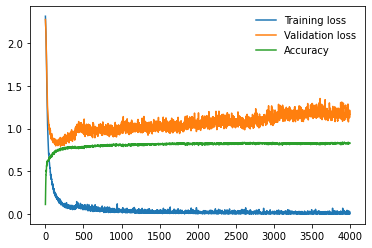

In [87]:
plt.plot(train_losses_gcnn, label='Training loss')
plt.plot(test_losses_gcnn, label='Validation loss')
plt.plot(accuracy_graph_gcnn, label='Accuracy')
plt.legend(frameon=False)

# Gaussian 2

In [16]:
gcnn2=CNN()
gcnn2=gcnn2.double()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gcnn2.parameters(), lr=0.0001)

train_losses_gcnn2, test_losses_gcnn2, accuracy_graph_gcnn2 = [], [], []

In [23]:
epochs = 1000
transform = transforms.Compose([transforms.GaussianBlur(kernel_size=7)])

for epoch in range(epochs):
    running_loss = 0
    mask_loss = 0

    currentdropout = 0.75

    i=0

    for images,labels in train_loader:
        train = Variable(images.view(-1,1,28,28))
        labels = Variable(labels)

        optimizer.zero_grad()

        drop = nn.Dropout(p=currentdropout)
        mask = drop(torch.rand(images.shape).double())

        images = images + transform(drop(mask).view(-1, 1, 28, 28)).view(-1, 784)
        images = torch.minimum(images, torch.ones(images.shape))
        train = Variable(images.view(-1,1,28,28))

        output = gcnn2(train)

        loss = criterion(output, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        i+=1

    else:
        test_loss = 0
        accuracy = 0
        
        with torch.no_grad(): #Turning off gradients to speed up
            gcnn2.eval()
            for images,labels in test_loader:
                
                test = Variable(images.view(-1,1,28,28))
                labels = Variable(labels)
                
                log_ps = gcnn2(test)
                test_loss += criterion(log_ps,labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim = 1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))

        gcnn2.train()        
        train_losses_gcnn2.append(running_loss/len(train_loader))
        test_losses_gcnn2.append(test_loss/len(test_loader))
        accuracy_graph_gcnn2.append(accuracy/len(test_loader))

        print("Epoch: {}/{}.. ".format(epoch+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(test_loader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))

Epoch: 1/1000..  Training Loss: 0.275..  Test Loss: 0.694..  Test Accuracy: 0.853
Epoch: 2/1000..  Training Loss: 0.111..  Test Loss: 0.725..  Test Accuracy: 0.847
Epoch: 3/1000..  Training Loss: 0.256..  Test Loss: 0.727..  Test Accuracy: 0.848
Epoch: 4/1000..  Training Loss: 0.176..  Test Loss: 0.729..  Test Accuracy: 0.847
Epoch: 5/1000..  Training Loss: 0.198..  Test Loss: 0.712..  Test Accuracy: 0.847
Epoch: 6/1000..  Training Loss: 0.192..  Test Loss: 0.719..  Test Accuracy: 0.845
Epoch: 7/1000..  Training Loss: 0.182..  Test Loss: 0.715..  Test Accuracy: 0.847
Epoch: 8/1000..  Training Loss: 0.250..  Test Loss: 0.721..  Test Accuracy: 0.850
Epoch: 9/1000..  Training Loss: 0.260..  Test Loss: 0.702..  Test Accuracy: 0.850
Epoch: 10/1000..  Training Loss: 0.278..  Test Loss: 0.729..  Test Accuracy: 0.849
Epoch: 11/1000..  Training Loss: 0.164..  Test Loss: 0.699..  Test Accuracy: 0.852
Epoch: 12/1000..  Training Loss: 0.217..  Test Loss: 0.718..  Test Accuracy: 0.849
Epoch: 13/100

Epoch: 100/1000..  Training Loss: 0.202..  Test Loss: 0.722..  Test Accuracy: 0.850
Epoch: 101/1000..  Training Loss: 0.117..  Test Loss: 0.767..  Test Accuracy: 0.842
Epoch: 102/1000..  Training Loss: 0.161..  Test Loss: 0.726..  Test Accuracy: 0.849
Epoch: 103/1000..  Training Loss: 0.259..  Test Loss: 0.734..  Test Accuracy: 0.844
Epoch: 104/1000..  Training Loss: 0.184..  Test Loss: 0.740..  Test Accuracy: 0.845
Epoch: 105/1000..  Training Loss: 0.164..  Test Loss: 0.733..  Test Accuracy: 0.844
Epoch: 106/1000..  Training Loss: 0.206..  Test Loss: 0.751..  Test Accuracy: 0.843
Epoch: 107/1000..  Training Loss: 0.203..  Test Loss: 0.739..  Test Accuracy: 0.846
Epoch: 108/1000..  Training Loss: 0.164..  Test Loss: 0.725..  Test Accuracy: 0.847
Epoch: 109/1000..  Training Loss: 0.212..  Test Loss: 0.728..  Test Accuracy: 0.847
Epoch: 110/1000..  Training Loss: 0.240..  Test Loss: 0.728..  Test Accuracy: 0.849
Epoch: 111/1000..  Training Loss: 0.149..  Test Loss: 0.721..  Test Accuracy

Epoch: 198/1000..  Training Loss: 0.203..  Test Loss: 0.729..  Test Accuracy: 0.845
Epoch: 199/1000..  Training Loss: 0.157..  Test Loss: 0.727..  Test Accuracy: 0.848
Epoch: 200/1000..  Training Loss: 0.163..  Test Loss: 0.719..  Test Accuracy: 0.849
Epoch: 201/1000..  Training Loss: 0.147..  Test Loss: 0.712..  Test Accuracy: 0.851
Epoch: 202/1000..  Training Loss: 0.191..  Test Loss: 0.726..  Test Accuracy: 0.848
Epoch: 203/1000..  Training Loss: 0.150..  Test Loss: 0.710..  Test Accuracy: 0.851
Epoch: 204/1000..  Training Loss: 0.141..  Test Loss: 0.715..  Test Accuracy: 0.850
Epoch: 205/1000..  Training Loss: 0.172..  Test Loss: 0.723..  Test Accuracy: 0.848
Epoch: 206/1000..  Training Loss: 0.296..  Test Loss: 0.728..  Test Accuracy: 0.849
Epoch: 207/1000..  Training Loss: 0.179..  Test Loss: 0.714..  Test Accuracy: 0.850
Epoch: 208/1000..  Training Loss: 0.211..  Test Loss: 0.707..  Test Accuracy: 0.851
Epoch: 209/1000..  Training Loss: 0.157..  Test Loss: 0.722..  Test Accuracy

Epoch: 296/1000..  Training Loss: 0.174..  Test Loss: 0.727..  Test Accuracy: 0.851
Epoch: 297/1000..  Training Loss: 0.126..  Test Loss: 0.729..  Test Accuracy: 0.850
Epoch: 298/1000..  Training Loss: 0.282..  Test Loss: 0.713..  Test Accuracy: 0.853
Epoch: 299/1000..  Training Loss: 0.182..  Test Loss: 0.706..  Test Accuracy: 0.854
Epoch: 300/1000..  Training Loss: 0.152..  Test Loss: 0.717..  Test Accuracy: 0.852
Epoch: 301/1000..  Training Loss: 0.191..  Test Loss: 0.740..  Test Accuracy: 0.850
Epoch: 302/1000..  Training Loss: 0.204..  Test Loss: 0.743..  Test Accuracy: 0.847
Epoch: 303/1000..  Training Loss: 0.221..  Test Loss: 0.698..  Test Accuracy: 0.853
Epoch: 304/1000..  Training Loss: 0.211..  Test Loss: 0.717..  Test Accuracy: 0.852
Epoch: 305/1000..  Training Loss: 0.173..  Test Loss: 0.731..  Test Accuracy: 0.850
Epoch: 306/1000..  Training Loss: 0.242..  Test Loss: 0.732..  Test Accuracy: 0.847
Epoch: 307/1000..  Training Loss: 0.188..  Test Loss: 0.731..  Test Accuracy

Epoch: 394/1000..  Training Loss: 0.249..  Test Loss: 0.738..  Test Accuracy: 0.847
Epoch: 395/1000..  Training Loss: 0.209..  Test Loss: 0.720..  Test Accuracy: 0.850
Epoch: 396/1000..  Training Loss: 0.185..  Test Loss: 0.739..  Test Accuracy: 0.848
Epoch: 397/1000..  Training Loss: 0.157..  Test Loss: 0.752..  Test Accuracy: 0.846
Epoch: 398/1000..  Training Loss: 0.180..  Test Loss: 0.730..  Test Accuracy: 0.847
Epoch: 399/1000..  Training Loss: 0.157..  Test Loss: 0.740..  Test Accuracy: 0.845
Epoch: 400/1000..  Training Loss: 0.173..  Test Loss: 0.751..  Test Accuracy: 0.846
Epoch: 401/1000..  Training Loss: 0.240..  Test Loss: 0.735..  Test Accuracy: 0.848
Epoch: 402/1000..  Training Loss: 0.221..  Test Loss: 0.741..  Test Accuracy: 0.847
Epoch: 403/1000..  Training Loss: 0.194..  Test Loss: 0.749..  Test Accuracy: 0.845
Epoch: 404/1000..  Training Loss: 0.202..  Test Loss: 0.767..  Test Accuracy: 0.842
Epoch: 405/1000..  Training Loss: 0.216..  Test Loss: 0.759..  Test Accuracy

Epoch: 492/1000..  Training Loss: 0.226..  Test Loss: 0.752..  Test Accuracy: 0.846
Epoch: 493/1000..  Training Loss: 0.228..  Test Loss: 0.751..  Test Accuracy: 0.846
Epoch: 494/1000..  Training Loss: 0.118..  Test Loss: 0.761..  Test Accuracy: 0.845
Epoch: 495/1000..  Training Loss: 0.191..  Test Loss: 0.754..  Test Accuracy: 0.847
Epoch: 496/1000..  Training Loss: 0.111..  Test Loss: 0.760..  Test Accuracy: 0.845
Epoch: 497/1000..  Training Loss: 0.159..  Test Loss: 0.735..  Test Accuracy: 0.848
Epoch: 498/1000..  Training Loss: 0.205..  Test Loss: 0.768..  Test Accuracy: 0.846
Epoch: 499/1000..  Training Loss: 0.234..  Test Loss: 0.756..  Test Accuracy: 0.845
Epoch: 500/1000..  Training Loss: 0.131..  Test Loss: 0.785..  Test Accuracy: 0.843
Epoch: 501/1000..  Training Loss: 0.175..  Test Loss: 0.763..  Test Accuracy: 0.845
Epoch: 502/1000..  Training Loss: 0.174..  Test Loss: 0.760..  Test Accuracy: 0.844
Epoch: 503/1000..  Training Loss: 0.268..  Test Loss: 0.789..  Test Accuracy

Epoch: 590/1000..  Training Loss: 0.173..  Test Loss: 0.753..  Test Accuracy: 0.846
Epoch: 591/1000..  Training Loss: 0.224..  Test Loss: 0.741..  Test Accuracy: 0.849
Epoch: 592/1000..  Training Loss: 0.189..  Test Loss: 0.760..  Test Accuracy: 0.848
Epoch: 593/1000..  Training Loss: 0.137..  Test Loss: 0.744..  Test Accuracy: 0.849
Epoch: 594/1000..  Training Loss: 0.179..  Test Loss: 0.764..  Test Accuracy: 0.846
Epoch: 595/1000..  Training Loss: 0.110..  Test Loss: 0.762..  Test Accuracy: 0.848
Epoch: 596/1000..  Training Loss: 0.249..  Test Loss: 0.784..  Test Accuracy: 0.843
Epoch: 597/1000..  Training Loss: 0.237..  Test Loss: 0.785..  Test Accuracy: 0.839
Epoch: 598/1000..  Training Loss: 0.177..  Test Loss: 0.763..  Test Accuracy: 0.845
Epoch: 599/1000..  Training Loss: 0.282..  Test Loss: 0.736..  Test Accuracy: 0.848
Epoch: 600/1000..  Training Loss: 0.218..  Test Loss: 0.742..  Test Accuracy: 0.850
Epoch: 601/1000..  Training Loss: 0.192..  Test Loss: 0.779..  Test Accuracy

Epoch: 688/1000..  Training Loss: 0.189..  Test Loss: 0.765..  Test Accuracy: 0.845
Epoch: 689/1000..  Training Loss: 0.192..  Test Loss: 0.772..  Test Accuracy: 0.845
Epoch: 690/1000..  Training Loss: 0.222..  Test Loss: 0.746..  Test Accuracy: 0.850
Epoch: 691/1000..  Training Loss: 0.140..  Test Loss: 0.741..  Test Accuracy: 0.848
Epoch: 692/1000..  Training Loss: 0.189..  Test Loss: 0.762..  Test Accuracy: 0.848
Epoch: 693/1000..  Training Loss: 0.160..  Test Loss: 0.768..  Test Accuracy: 0.848
Epoch: 694/1000..  Training Loss: 0.207..  Test Loss: 0.733..  Test Accuracy: 0.850
Epoch: 695/1000..  Training Loss: 0.179..  Test Loss: 0.757..  Test Accuracy: 0.845
Epoch: 696/1000..  Training Loss: 0.243..  Test Loss: 0.763..  Test Accuracy: 0.847
Epoch: 697/1000..  Training Loss: 0.126..  Test Loss: 0.724..  Test Accuracy: 0.853
Epoch: 698/1000..  Training Loss: 0.197..  Test Loss: 0.762..  Test Accuracy: 0.844
Epoch: 699/1000..  Training Loss: 0.184..  Test Loss: 0.747..  Test Accuracy

Epoch: 786/1000..  Training Loss: 0.239..  Test Loss: 0.798..  Test Accuracy: 0.840
Epoch: 787/1000..  Training Loss: 0.186..  Test Loss: 0.778..  Test Accuracy: 0.843
Epoch: 788/1000..  Training Loss: 0.169..  Test Loss: 0.774..  Test Accuracy: 0.844
Epoch: 789/1000..  Training Loss: 0.202..  Test Loss: 0.745..  Test Accuracy: 0.848
Epoch: 790/1000..  Training Loss: 0.192..  Test Loss: 0.811..  Test Accuracy: 0.840
Epoch: 791/1000..  Training Loss: 0.089..  Test Loss: 0.807..  Test Accuracy: 0.842
Epoch: 792/1000..  Training Loss: 0.230..  Test Loss: 0.810..  Test Accuracy: 0.841
Epoch: 793/1000..  Training Loss: 0.218..  Test Loss: 0.784..  Test Accuracy: 0.843
Epoch: 794/1000..  Training Loss: 0.288..  Test Loss: 0.774..  Test Accuracy: 0.847
Epoch: 795/1000..  Training Loss: 0.174..  Test Loss: 0.760..  Test Accuracy: 0.848
Epoch: 796/1000..  Training Loss: 0.124..  Test Loss: 0.785..  Test Accuracy: 0.844
Epoch: 797/1000..  Training Loss: 0.173..  Test Loss: 0.784..  Test Accuracy

Epoch: 884/1000..  Training Loss: 0.113..  Test Loss: 0.769..  Test Accuracy: 0.846
Epoch: 885/1000..  Training Loss: 0.255..  Test Loss: 0.805..  Test Accuracy: 0.839
Epoch: 886/1000..  Training Loss: 0.169..  Test Loss: 0.799..  Test Accuracy: 0.843
Epoch: 887/1000..  Training Loss: 0.268..  Test Loss: 0.776..  Test Accuracy: 0.845
Epoch: 888/1000..  Training Loss: 0.191..  Test Loss: 0.809..  Test Accuracy: 0.839
Epoch: 889/1000..  Training Loss: 0.199..  Test Loss: 0.772..  Test Accuracy: 0.844
Epoch: 890/1000..  Training Loss: 0.150..  Test Loss: 0.768..  Test Accuracy: 0.848
Epoch: 891/1000..  Training Loss: 0.123..  Test Loss: 0.760..  Test Accuracy: 0.850
Epoch: 892/1000..  Training Loss: 0.188..  Test Loss: 0.760..  Test Accuracy: 0.849
Epoch: 893/1000..  Training Loss: 0.134..  Test Loss: 0.785..  Test Accuracy: 0.845
Epoch: 894/1000..  Training Loss: 0.126..  Test Loss: 0.789..  Test Accuracy: 0.845
Epoch: 895/1000..  Training Loss: 0.222..  Test Loss: 0.803..  Test Accuracy

Epoch: 982/1000..  Training Loss: 0.125..  Test Loss: 0.748..  Test Accuracy: 0.850
Epoch: 983/1000..  Training Loss: 0.153..  Test Loss: 0.798..  Test Accuracy: 0.844
Epoch: 984/1000..  Training Loss: 0.165..  Test Loss: 0.761..  Test Accuracy: 0.846
Epoch: 985/1000..  Training Loss: 0.162..  Test Loss: 0.759..  Test Accuracy: 0.847
Epoch: 986/1000..  Training Loss: 0.127..  Test Loss: 0.781..  Test Accuracy: 0.842
Epoch: 987/1000..  Training Loss: 0.193..  Test Loss: 0.767..  Test Accuracy: 0.847
Epoch: 988/1000..  Training Loss: 0.148..  Test Loss: 0.754..  Test Accuracy: 0.849
Epoch: 989/1000..  Training Loss: 0.181..  Test Loss: 0.746..  Test Accuracy: 0.851
Epoch: 990/1000..  Training Loss: 0.120..  Test Loss: 0.757..  Test Accuracy: 0.850
Epoch: 991/1000..  Training Loss: 0.194..  Test Loss: 0.737..  Test Accuracy: 0.851
Epoch: 992/1000..  Training Loss: 0.152..  Test Loss: 0.763..  Test Accuracy: 0.846
Epoch: 993/1000..  Training Loss: 0.151..  Test Loss: 0.789..  Test Accuracy

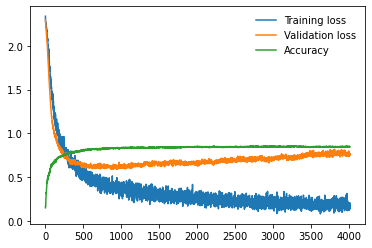

In [86]:
plt.plot(train_losses_gcnn2, label='Training loss')
plt.plot(test_losses_gcnn2, label='Validation loss')
plt.plot(accuracy_graph_gcnn2, label='Accuracy')
plt.legend(frameon=False)

# Adversarial Mask CNN, Loss 1

In [91]:
#loss = number of activated neurons in final layer - difference between label and classification

adv=Adv2()
adv=adv.double()

cnn=CNN()
cnn=cnn.double()

criterion = nn.CrossEntropyLoss()
optCNN = torch.optim.Adam(cnn.parameters(), lr=0.0001)

optAdv = torch.optim.Adam(adv.parameters(), lr=0.0001)

train_losses_adv1, test_losses_adv1, accuracy_graph_adv1 = [], [], []
sample_images_adv1=[]
sample_masked_adv1=[]
sample_mask_adv1=[]

In [93]:
epochs = 10000

for epoch in range(epochs):
    running_loss = 0
    mask_loss = 0

    currentdropout = 0.95
    
    if(epoch>400):
      currentdropout=0.75
    else:
      currentdropout = 0.95 - epoch*(0.15/400)

    i=0

    for images,labels in train_loader:
        train = Variable(images.view(-1,1,28,28))
        labels = Variable(labels)

        if(i==0 and epoch%10==0):
          sample_images_adv1.append(train.clone().detach().numpy())

        optAdv.zero_grad()
        optCNN.zero_grad()

        mask = adv(train)
        finaldrop = nn.Dropout(p=currentdropout)
        mask = finaldrop(mask)

        images = images + mask
        images = torch.minimum(images, torch.ones(images.shape))
        train = Variable(images.view(-1,1,28,28))

        if(i==0 and epoch%10==0):
          sample_masked_adv1.append(train.clone().detach().numpy())
          sample_mask_adv1.append(mask.clone().detach().view(-1, 1, 28, 28).numpy())

        output = cnn(train)

        lossAdv = -torch.log(criterion(output, labels))
        lossCNN = criterion(output, labels)
        
        # print(lossAdv)
        # print(lossCNN)

        if(i%3==0):
          lossAdv.backward()
          optAdv.step()
        else:
          lossCNN.backward()
          optCNN.step()
        
        mask_loss += lossAdv.item()
        running_loss += lossCNN.item()
        i+=1

    else:
        test_loss = 0
        accuracy = 0
        
        with torch.no_grad(): #Turning off gradients to speed up
            cnn.eval()
            for images,labels in test_loader:
                
                test = Variable(images.view(-1,1,28,28))
                labels = Variable(labels)
                
                log_ps = cnn(test)
                test_loss += criterion(log_ps,labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim = 1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        cnn.train()        
        train_losses_adv1.append(running_loss/len(train_loader))
        test_losses_adv1.append(test_loss/len(test_loader))
        accuracy_graph_adv1.append(accuracy/len(test_loader))

        print("Epoch: {}/{}.. ".format(epoch+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
              "Mask Loss: {:.3f}.. ".format(mask_loss/len(train_loader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(test_loader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))

Epoch: 1/10000..  Training Loss: 0.012..  Mask Loss: 6.022..  Test Loss: 1.159..  Test Accuracy: 0.799
Epoch: 2/10000..  Training Loss: 0.006..  Mask Loss: 6.583..  Test Loss: 1.139..  Test Accuracy: 0.801
Epoch: 3/10000..  Training Loss: 0.003..  Mask Loss: 7.081..  Test Loss: 1.127..  Test Accuracy: 0.803
Epoch: 4/10000..  Training Loss: 0.007..  Mask Loss: 7.250..  Test Loss: 1.120..  Test Accuracy: 0.804
Epoch: 5/10000..  Training Loss: 0.003..  Mask Loss: 6.530..  Test Loss: 1.112..  Test Accuracy: 0.806
Epoch: 6/10000..  Training Loss: 0.004..  Mask Loss: 6.928..  Test Loss: 1.106..  Test Accuracy: 0.806
Epoch: 7/10000..  Training Loss: 0.004..  Mask Loss: 6.938..  Test Loss: 1.095..  Test Accuracy: 0.808
Epoch: 8/10000..  Training Loss: 0.002..  Mask Loss: 6.751..  Test Loss: 1.089..  Test Accuracy: 0.810
Epoch: 9/10000..  Training Loss: 0.003..  Mask Loss: 6.701..  Test Loss: 1.083..  Test Accuracy: 0.811
Epoch: 10/10000..  Training Loss: 0.015..  Mask Loss: 7.063..  Test Loss:

KeyboardInterrupt: 

In [85]:

plt.plot(train_losses_adv1, label='Training loss')
plt.plot(test_losses_adv1, label='Validation loss')
plt.plot(accuracy_graph_adv1, label='Accuracy')
plt.legend(frameon=False)

NameError: name 'train_losses_adv1' is not defined

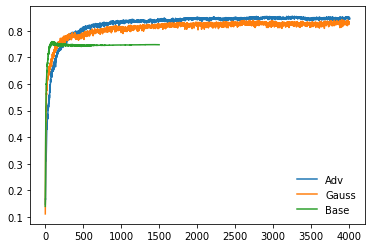

In [83]:
plt.plot(accuracy_graph_gcnn2, label='Adv')
plt.plot(accuracy_graph_gcnn, label='Gauss')
plt.plot(accuracy_graph_basecnn, label='Base')
plt.legend(frameon=False)

# Adversarial Mask CNN, Loss 2

In [25]:
#loss = number of activated neurons in final layer - difference between label and classification

adv=Adv3()
adv=adv.double()

cnn=CNN()
cnn=cnn.double()

criterion = nn.CrossEntropyLoss()
optCNN = torch.optim.Adam(cnn.parameters(), lr=0.0001)

optAdv = torch.optim.Adam(adv.parameters(), lr=0.0001)

train_losses_adv2, test_losses_adv2, accuracy_graph_adv2 = [], [], []
sample_images_adv2=[]
sample_masked_adv2=[]
sample_mask_adv2=[]

In [26]:
def klduniform(p):
    maxp=torch.nn.MaxPool2d(6, stride=5)
    p=maxp(p.view(-1, 1, 28, 28))
    q=torch.ones(p.shape) * torch.mean(p)
    kl=p*torch.log(p/q)    
    return torch.sum(kl)
    
def kld(p, q):
    maxp=torch.nn.MaxPool2d(6, stride=5)
    p=maxp(p.view(-1, 1, 28, 28))
    q=maxp(q.view(-1, 1, 28, 28))
    kl=p*torch.log(p/q)    
    return torch.sum(kl)

In [28]:
epochs = 5000

previous_mask = []
transform = transforms.Compose([transforms.GaussianBlur(kernel_size=7)])

for epoch in range(epochs):
    running_loss = 0
    mask_loss = 0

    i=0

    for images,labels in train_loader:
        train = Variable(images.view(-1,1,28,28))
        labels = Variable(labels)


        optAdv.zero_grad()
        optCNN.zero_grad()
        
        if(i==0 and epoch%10==0):
            sample_images_adv2.append(train.clone().detach().numpy())
            
        current = 0.7
        
        mask = adv(train)
        drop = nn.Dropout(p=current)
        
        images = images + transform(drop(mask).view(-1, 1, 28, 28)).view(-1, 784)
        images = torch.minimum(images, torch.ones(images.shape))
        train = Variable(images.view(-1, 1, 28, 28))

        if(i==0 and epoch%10==0):
            sample_masked_adv2.append(train.clone().detach().numpy())
            sample_mask_adv2.append(mask.clone().detach().view(-1, 1, 28, 28).numpy())

        output = cnn(train)
        
        
        if(i%3==0 and epoch>0):
            lossAdv = - torch.log(criterion(output, labels)) -  klduniform(mask) - kld(mask, previous_mask)
            lossAdv.backward()
            optAdv.step()
            mask_loss += lossAdv.item()
          
        else:
            lossCNN = criterion(output, labels)
            lossCNN.backward()
            optCNN.step()
            running_loss += lossCNN.item()
          
        i+=1
        previous_mask = mask.clone().detach()

    else:
        test_loss = 0
        accuracy = 0
        
        with torch.no_grad(): #Turning off gradients to speed up
            cnn.eval()
            for images,labels in test_loader:
                
                test = Variable(images.view(-1,1,28,28))
                labels = Variable(labels)
                
                log_ps = cnn(test)
                test_loss += criterion(log_ps,labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim = 1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        cnn.train()        
        train_losses_adv2.append(running_loss/len(train_loader))
        test_losses_adv2.append(test_loss/len(test_loader))
        accuracy_graph_adv2.append(accuracy/len(test_loader))

        print("Epoch: {}/{}.. ".format(epoch+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
              "Mask Loss: {:.3f}.. ".format(mask_loss/len(train_loader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(test_loader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))

Epoch: 1/5000..  Training Loss: 0.119..  Mask Loss: 0.000..  Test Loss: 0.857..  Test Accuracy: 0.833
Epoch: 2/5000..  Training Loss: 0.089..  Mask Loss: 1.849..  Test Loss: 0.868..  Test Accuracy: 0.829
Epoch: 3/5000..  Training Loss: 0.081..  Mask Loss: 1.843..  Test Loss: 0.887..  Test Accuracy: 0.827
Epoch: 4/5000..  Training Loss: 0.096..  Mask Loss: 1.753..  Test Loss: 0.837..  Test Accuracy: 0.832
Epoch: 5/5000..  Training Loss: 0.137..  Mask Loss: 1.701..  Test Loss: 0.860..  Test Accuracy: 0.831
Epoch: 6/5000..  Training Loss: 0.101..  Mask Loss: 2.044..  Test Loss: 0.819..  Test Accuracy: 0.836
Epoch: 7/5000..  Training Loss: 0.077..  Mask Loss: 1.675..  Test Loss: 0.836..  Test Accuracy: 0.833
Epoch: 8/5000..  Training Loss: 0.070..  Mask Loss: 1.849..  Test Loss: 0.827..  Test Accuracy: 0.834
Epoch: 9/5000..  Training Loss: 0.054..  Mask Loss: 1.593..  Test Loss: 0.854..  Test Accuracy: 0.829
Epoch: 10/5000..  Training Loss: 0.087..  Mask Loss: 1.663..  Test Loss: 0.838..  

KeyboardInterrupt: 

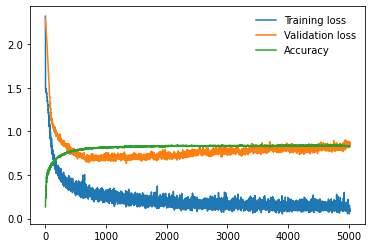

In [84]:
plt.plot(train_losses_adv2, label='Training loss')
plt.plot(test_losses_adv2, label='Validation loss')
plt.plot(accuracy_graph_adv2, label='Accuracy')
plt.legend(frameon=False)

# Analysis


NameError: name 'sample_images_gcnn2' is not defined

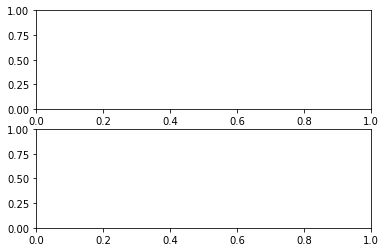

In [57]:
# Display image next to mask

epoch = 1000
image = 5

f, axarr = plt.subplots(2)

axarr[0].imshow(sample_images_gcnn[epoch][image][0])
axarr[1].imshow(sample_masked_gcnn[epoch][image][0])

NameError: name 'sample_images_adv1' is not defined

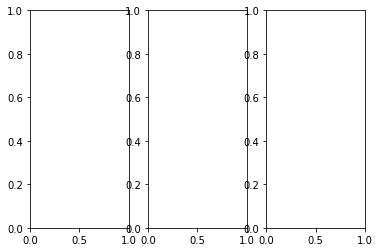

In [142]:
epoch = 10
image = 0

f, axarr = plt.subplots(1,3)

axarr[0].imshow(sample_images_adv1[epoch][image][0])
axarr[1].imshow(sample_masked_adv1[epoch][image][0])
axarr[2].imshow(sample_mask_adv1[epoch][image][0])

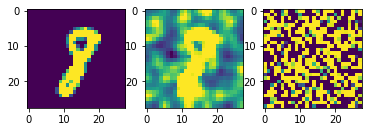

In [185]:
epoch = 482
image = 0

# transform = transforms.Compose([transforms.GaussianBlur(kernel_size=5)])
# blur = transform(torch.from_numpy(sample_mask_adv2[epoch][image][0]).view(1, 28, 28)).view(28, 28).numpy()

f, axarr = plt.subplots(1,3)

axarr[0].imshow(sample_images_adv2[epoch][image][0])
axarr[1].imshow(sample_masked_adv2[epoch][image][0])
axarr[2].imshow(np.clip(sample_mask_adv2[epoch][image][0], 0, 1.0))

In [258]:
sample_masked_adv2[epoch][image][0]

array([[1.        , 1.        , 1.        , 0.71428571, 0.71428571,
        0.71428571, 1.        , 0.71428571, 0.        , 1.        ,
        0.71428571, 0.        , 1.        , 0.71428571, 0.        ,
        1.        , 0.71428571, 1.        , 0.        , 0.71428571,
        0.73539753, 0.71428571, 1.        , 0.71428571, 0.        ,
        0.        , 1.        , 0.71428571],
       [0.        , 1.        , 1.        , 1.        , 1.        ,
        0.        , 1.        , 0.        , 1.        , 0.        ,
        0.71428571, 1.        , 0.        , 0.        , 0.71428571,
        0.71428571, 0.71428571, 0.        , 1.        , 1.        ,
        0.71428571, 0.        , 0.71428571, 0.        , 1.        ,
        0.71428571, 0.        , 0.71428571],
       [0.71428571, 0.        , 0.71428571, 0.71428571, 0.71428571,
        0.71428571, 0.71428571, 0.        , 1.        , 1.        ,
        0.71428571, 0.        , 0.71428571, 0.        , 0.        ,
        0.71428571, 0.    

In [293]:
transform = transforms.Compose([transforms.GaussianBlur(kernel_size=3)])
transform(torch.from_numpy(sample_mask_adv2[epoch][image][0]).view(1, 28, 28)).numpy()

tensor([[[ 3.8962e-01,  5.2245e-02, -1.0626e-01,  6.8432e-01,  6.9485e-01,
           5.8065e-01,  6.4448e-01,  8.8485e-01,  7.1800e-01,  3.8096e-01,
           5.7106e-01,  7.3791e-01,  1.9029e-01,  3.2319e-01,  8.6475e-01,
           8.7977e-01,  4.8084e-01,  3.8043e-01,  1.7568e-01,  5.6528e-01,
           8.6474e-01,  5.3652e-01, -2.2389e-02,  1.4896e-01,  5.8102e-01,
           7.0135e-01,  7.4971e-03, -1.1618e-01],
         [ 2.2806e-01,  4.1010e-01,  4.9684e-02,  4.6069e-01,  2.2283e-01,
           1.4983e-01,  1.6723e-01,  8.0011e-01,  9.2075e-01,  6.9052e-01,
           3.7219e-01,  7.7890e-01,  7.3578e-01,  8.0363e-01,  9.2549e-01,
           6.4868e-01, -2.9933e-02, -3.0974e-02,  3.3752e-01,  4.0230e-01,
           6.2164e-01,  3.1229e-01, -1.2613e-02,  2.5969e-01,  4.2025e-01,
           6.0486e-01,  3.6202e-01,  5.0456e-01],
         [ 1.2448e-01,  3.5685e-01, -1.8863e-01, -9.1104e-02, -1.5623e-01,
           3.5350e-01,  6.6370e-03,  6.2988e-01,  9.6035e-01,  9.1075e-01,


In [90]:
len(test_loader)

1000

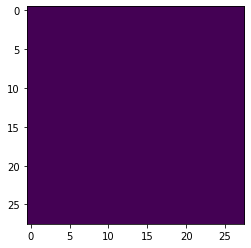

In [209]:
plt.imshow(np.ceil(train[0][0].numpy()+0.001))

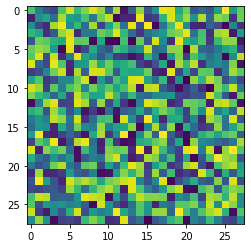

In [202]:
a= np.random.rand(28,28)
plt.imshow(a)